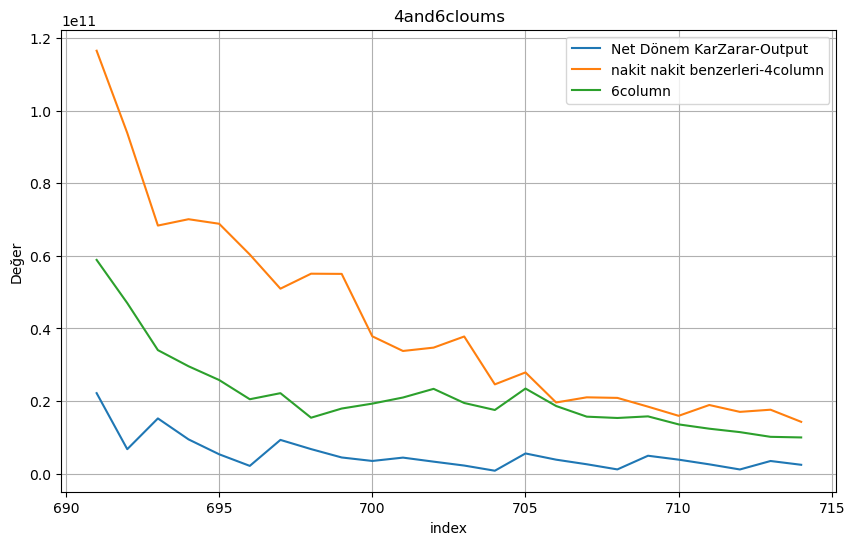

Corr Matrix


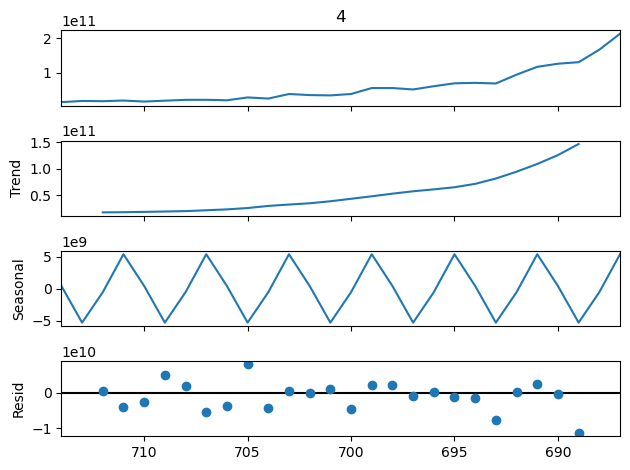

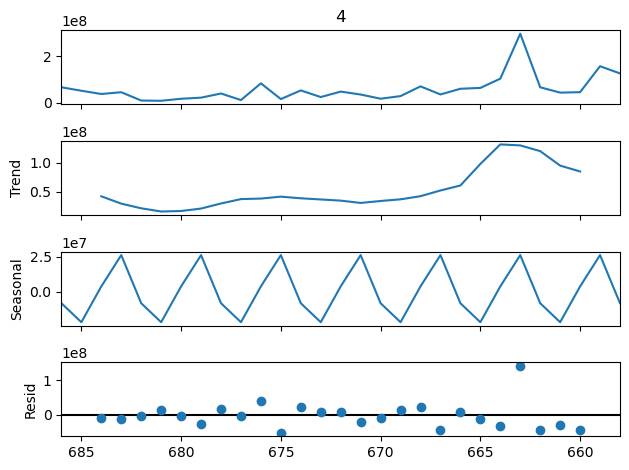

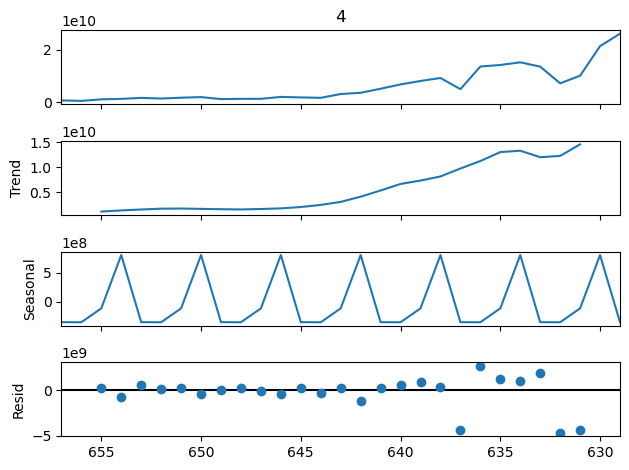

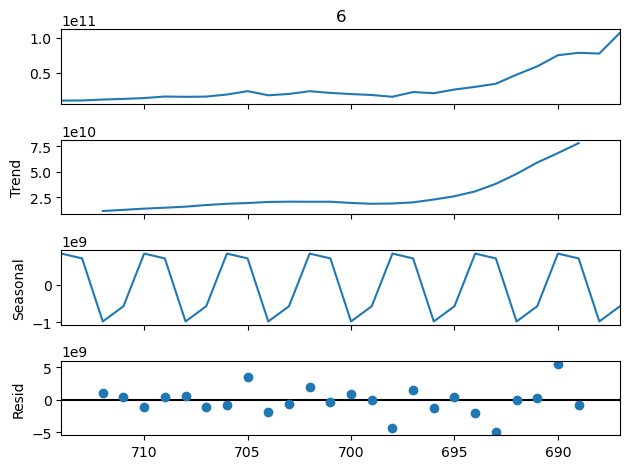

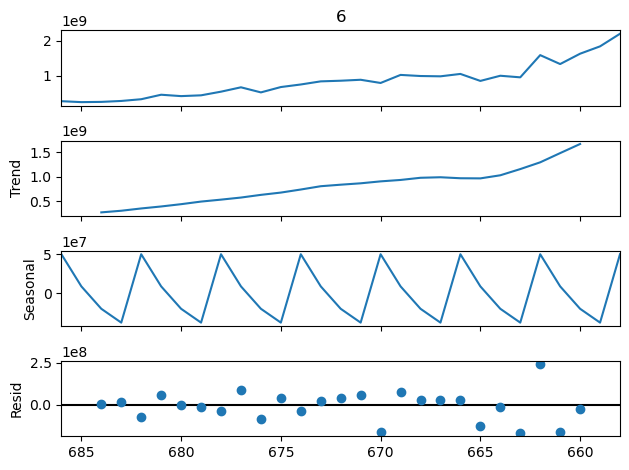

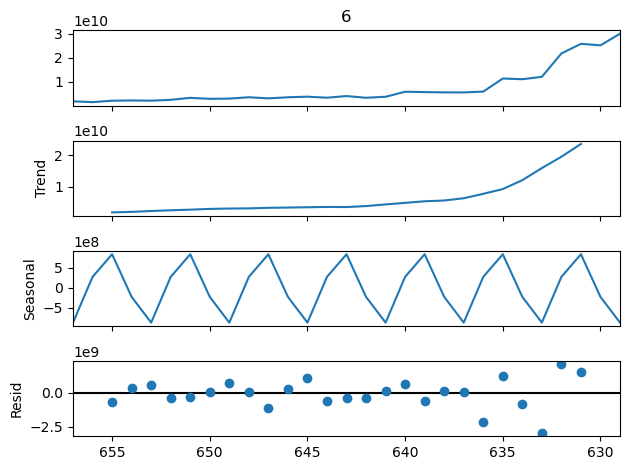

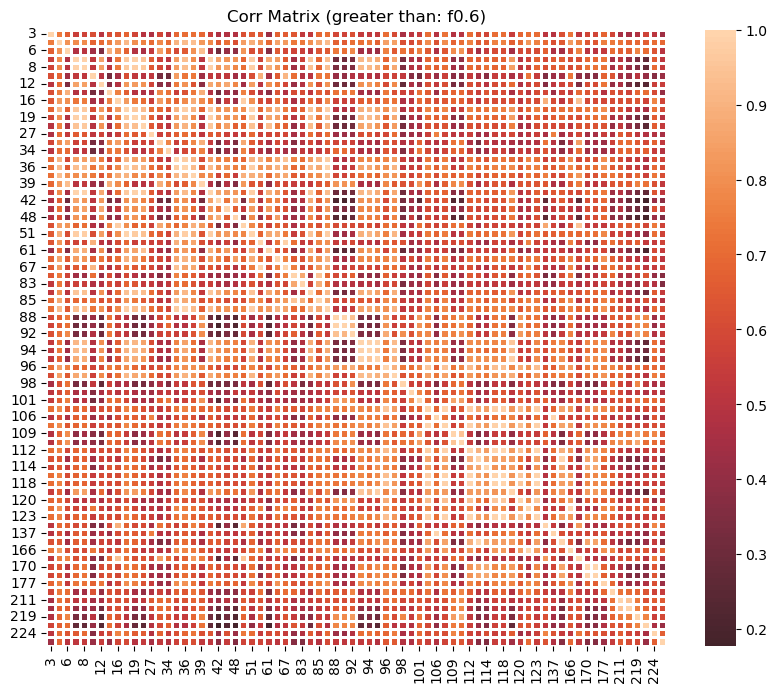

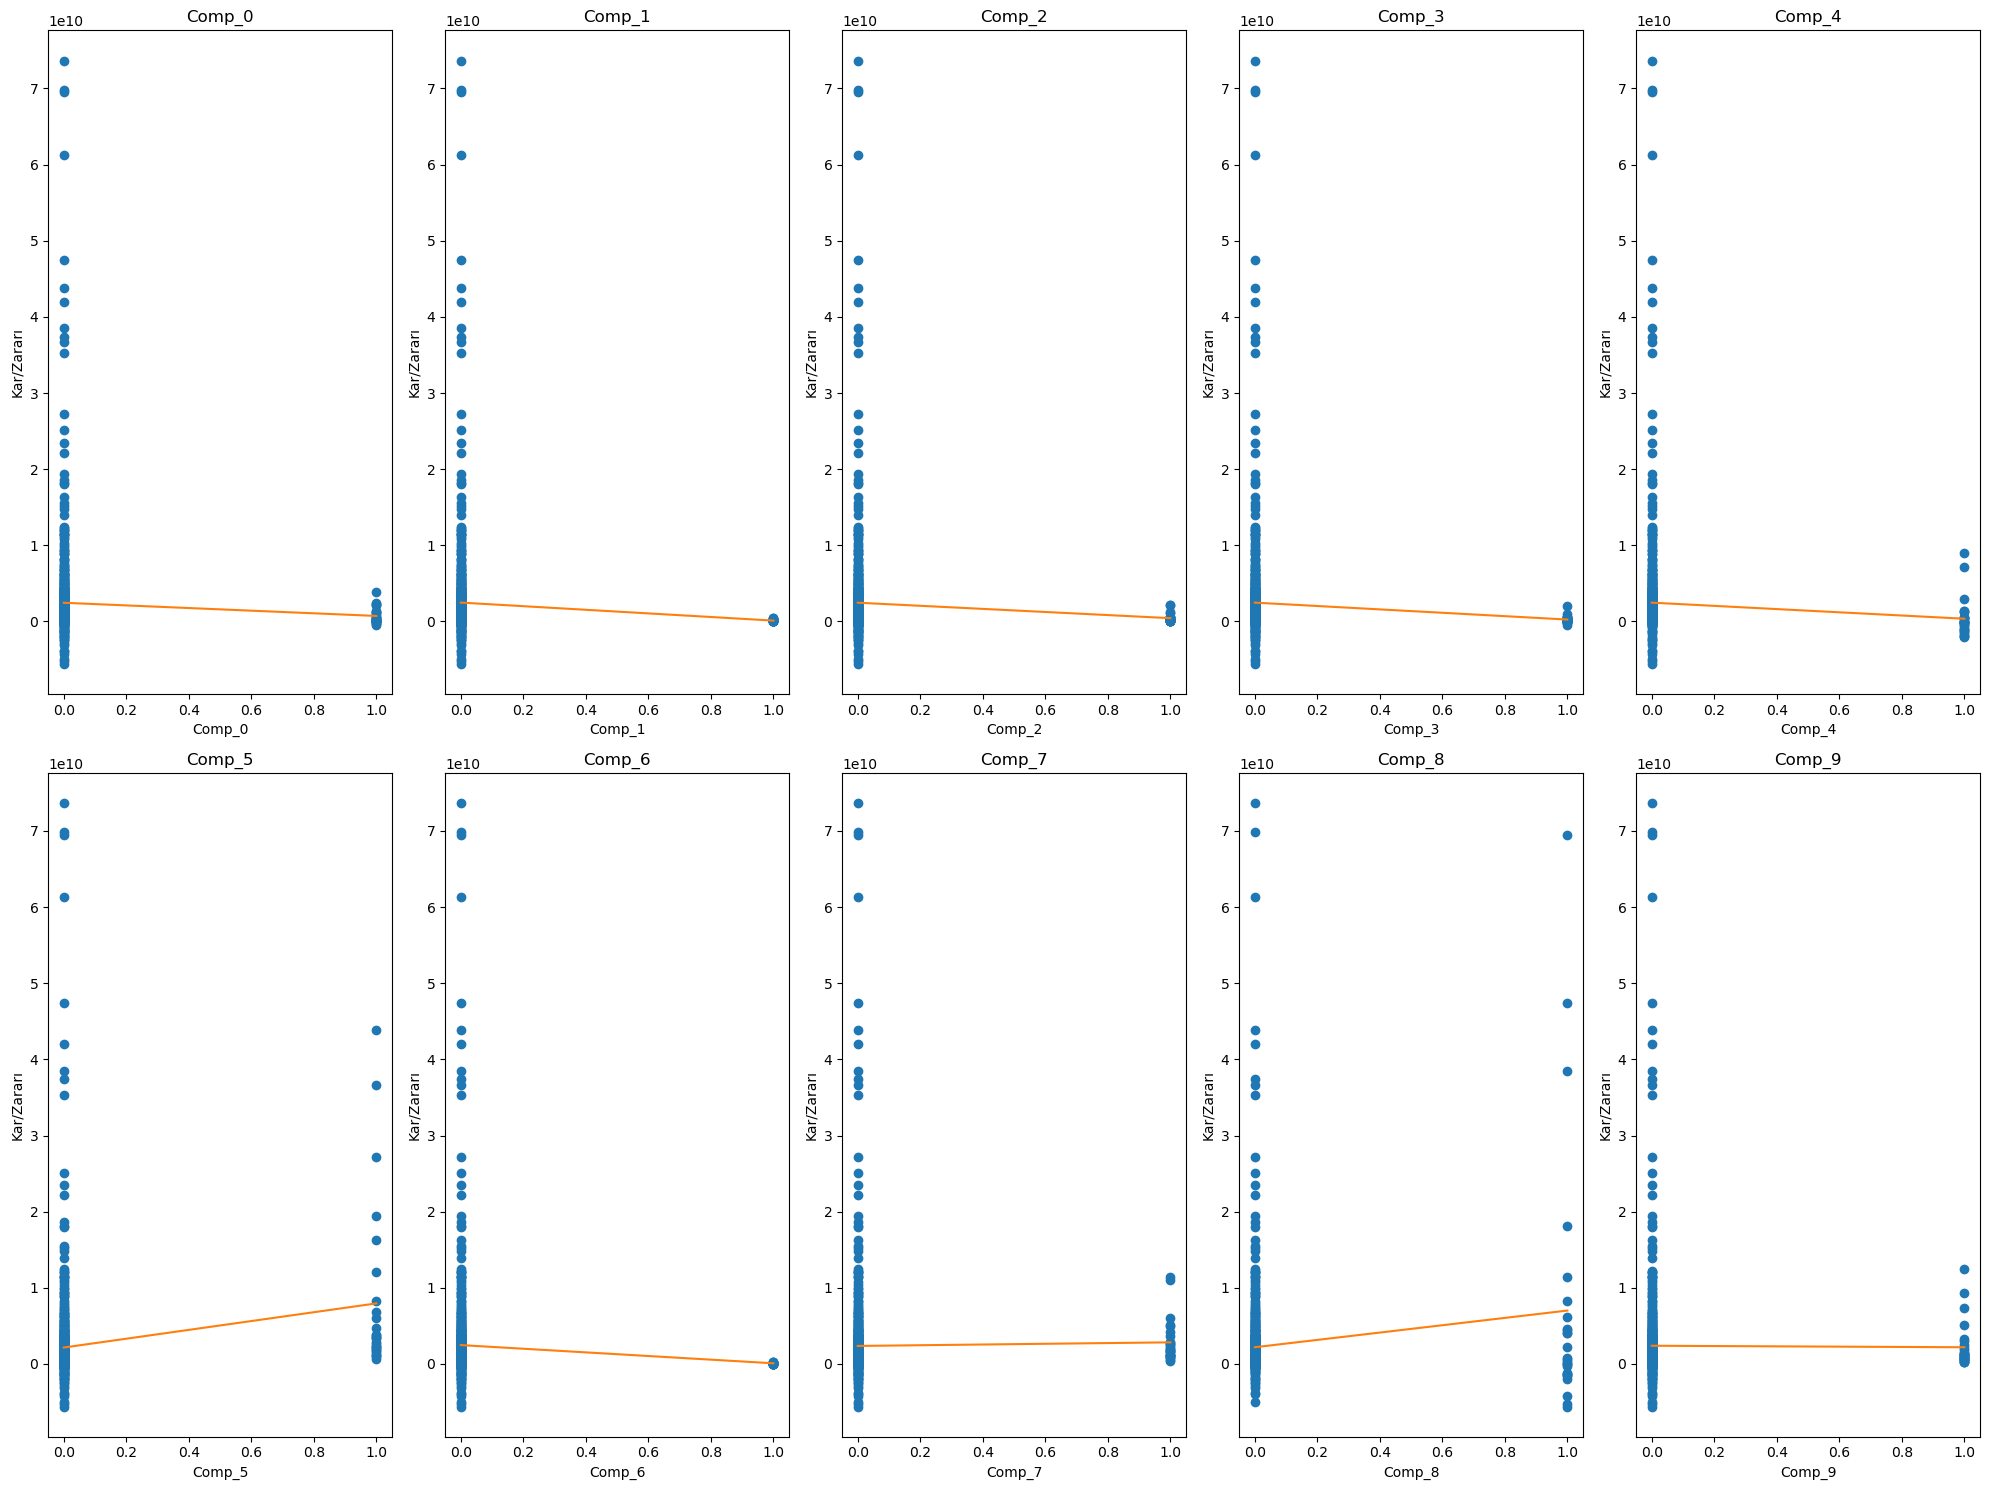

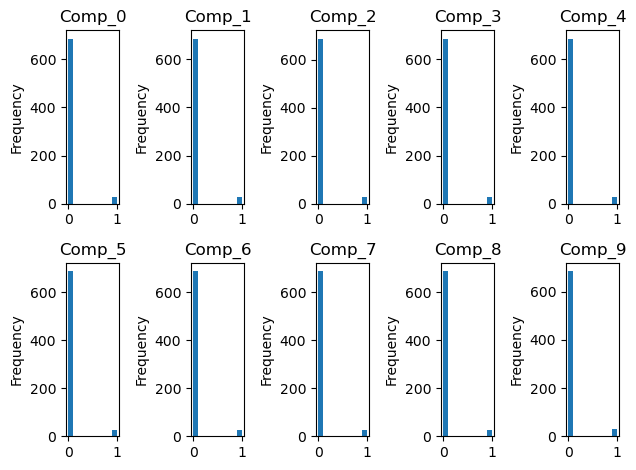

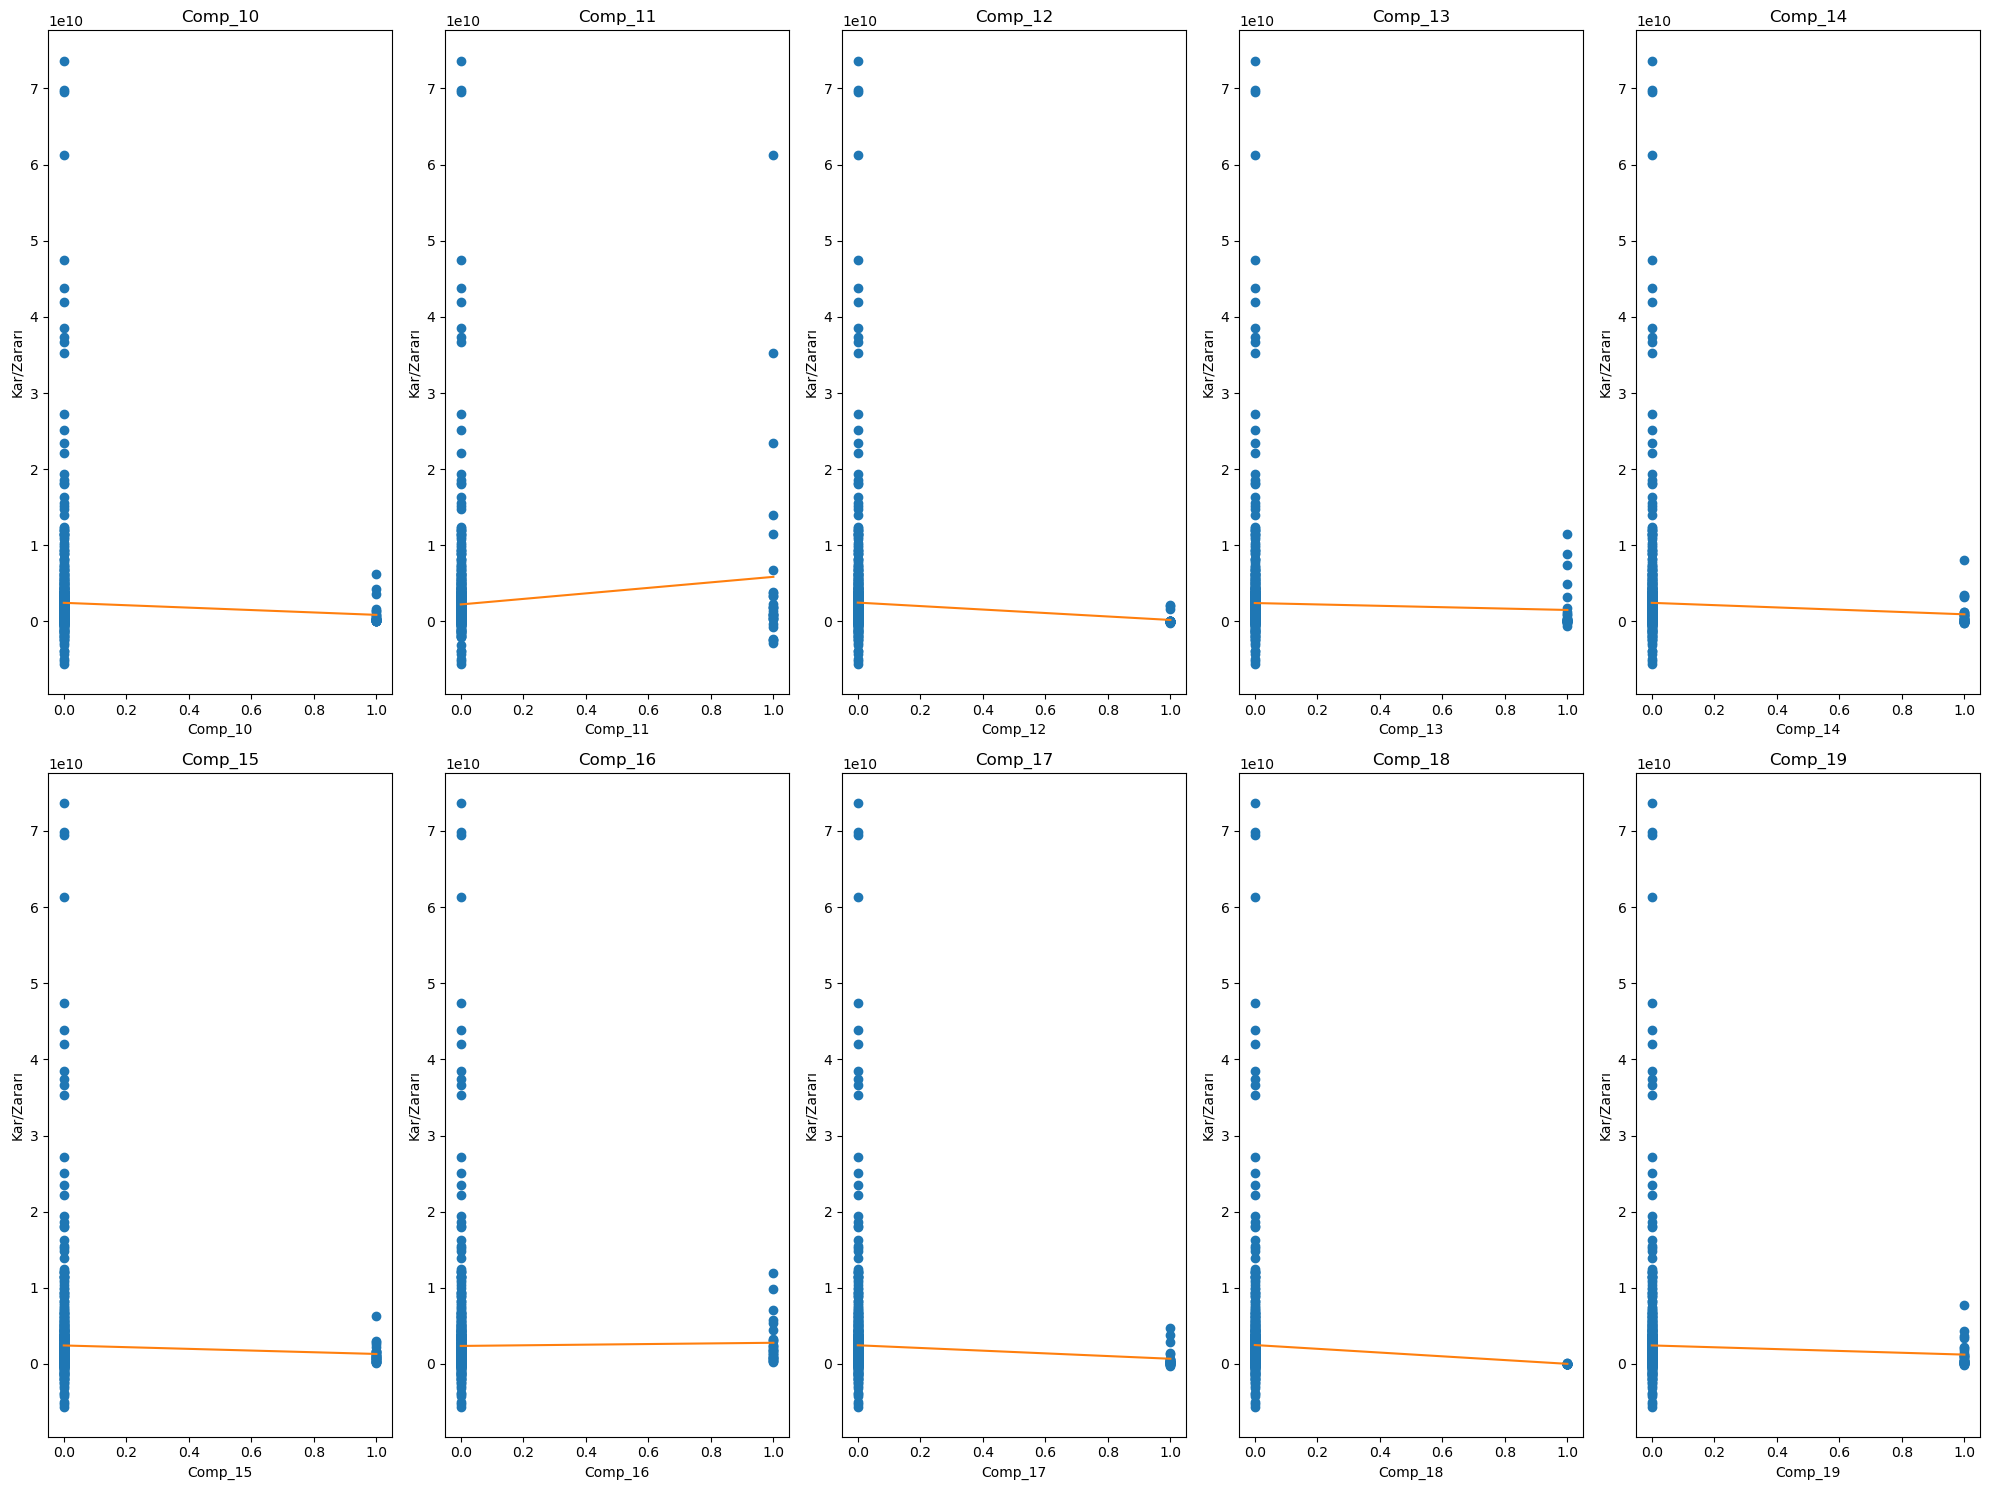

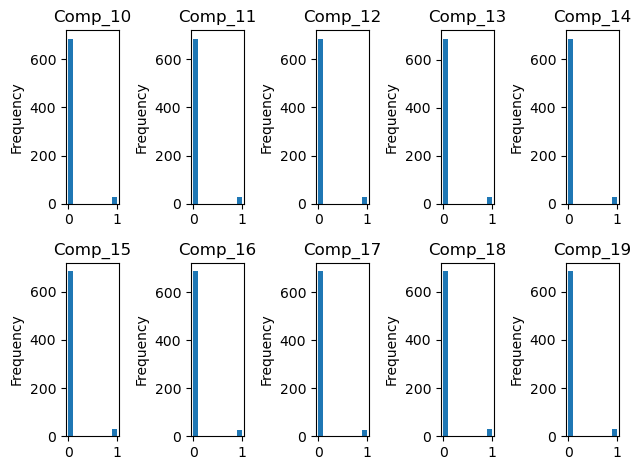

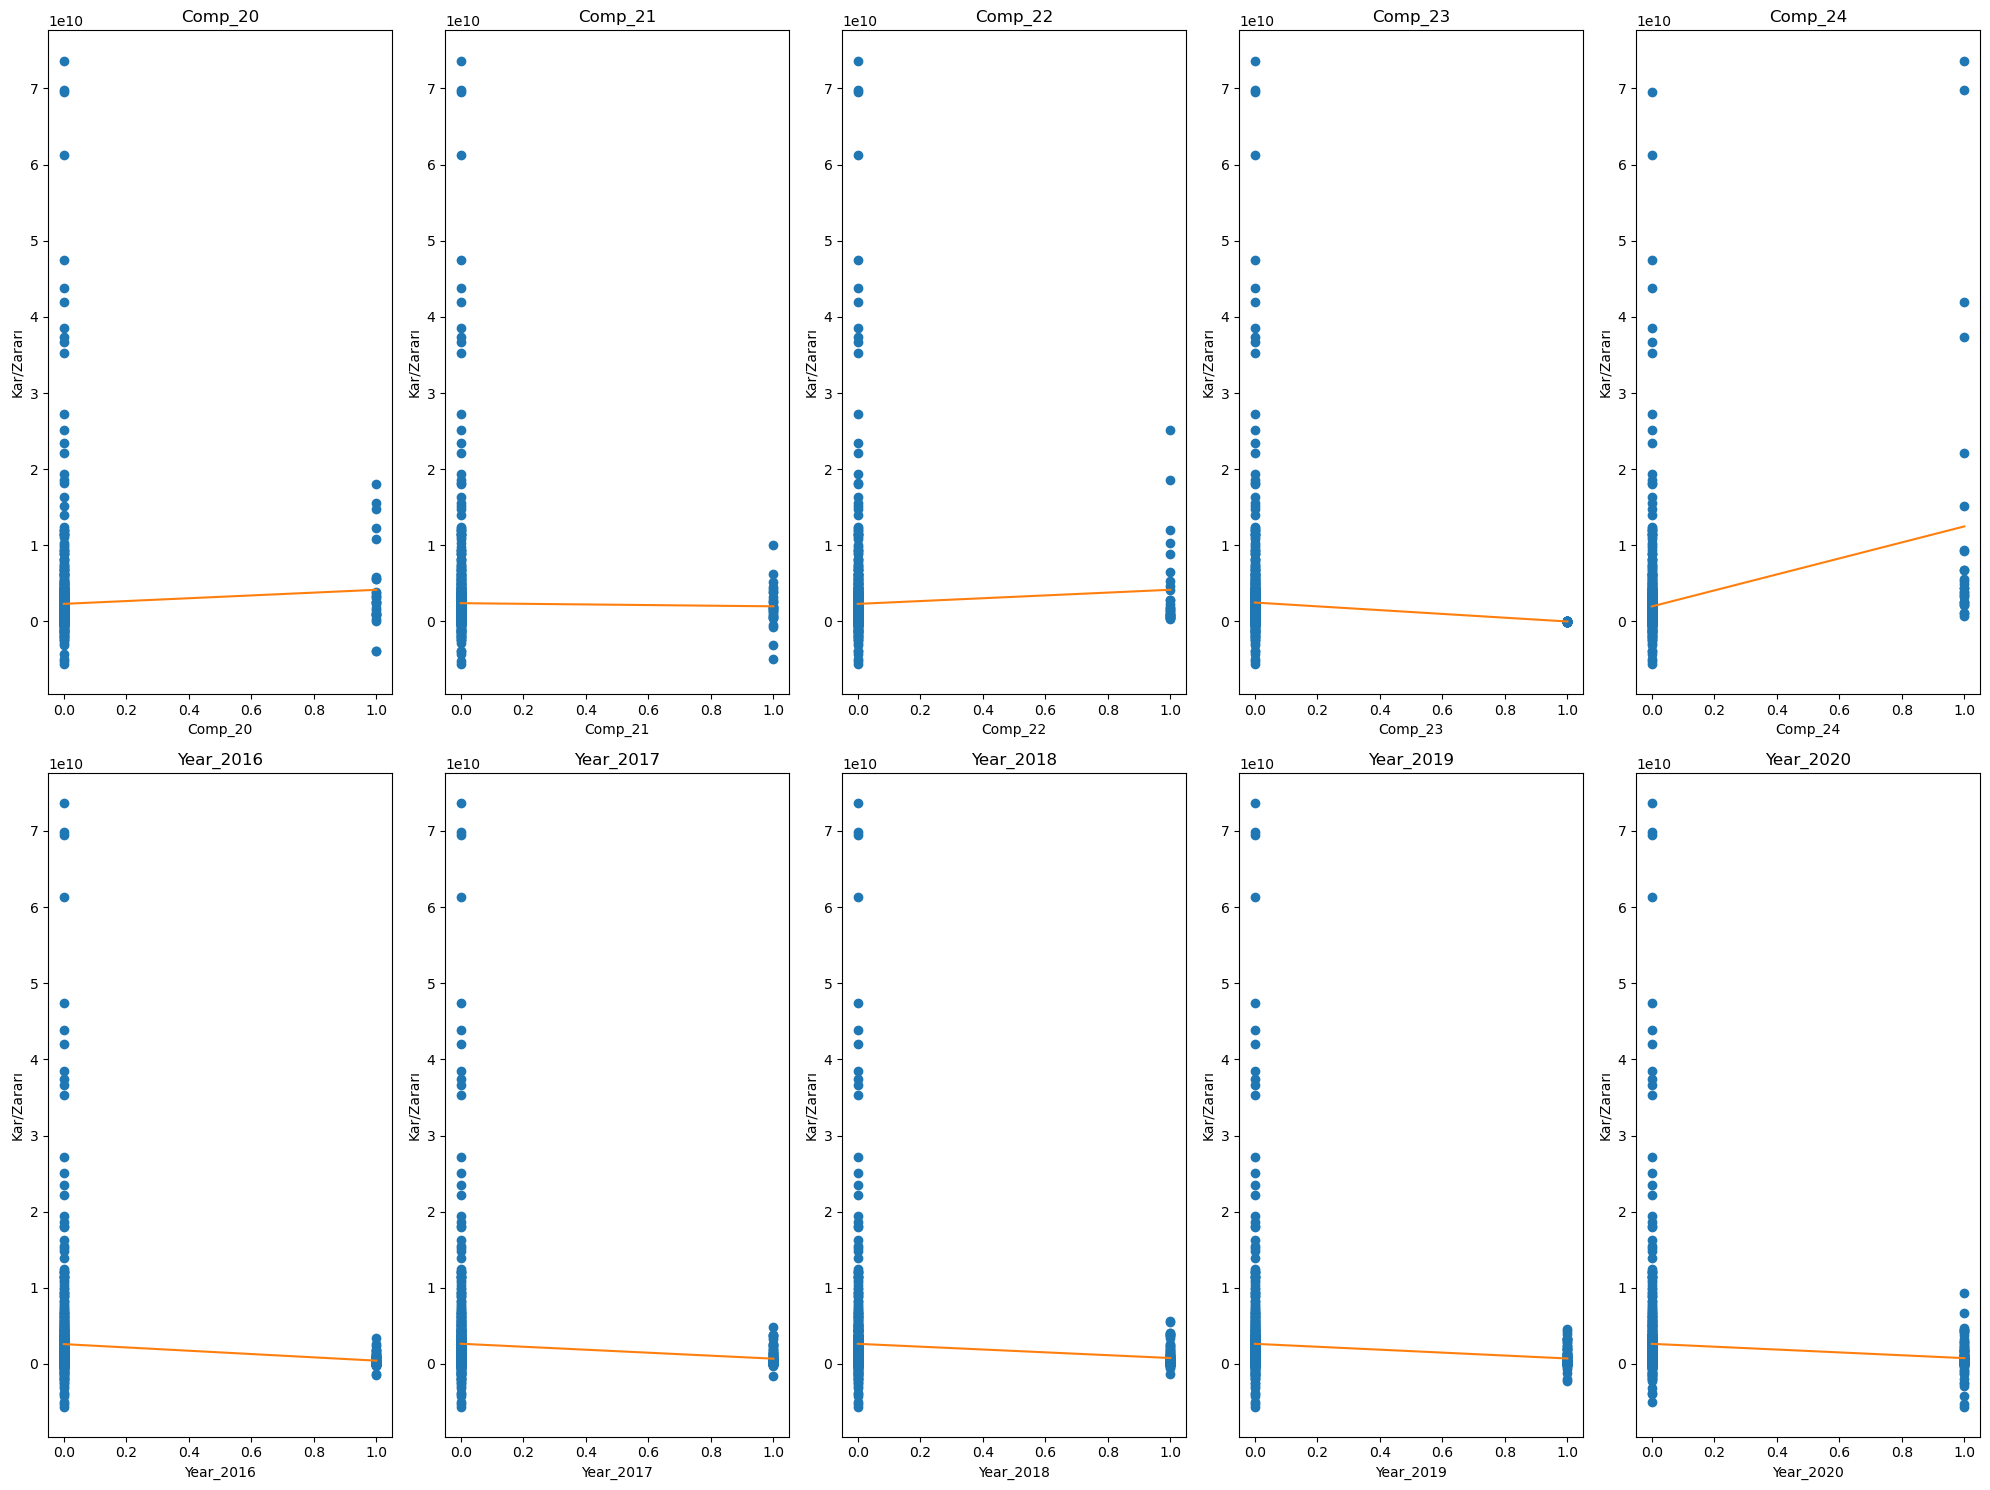

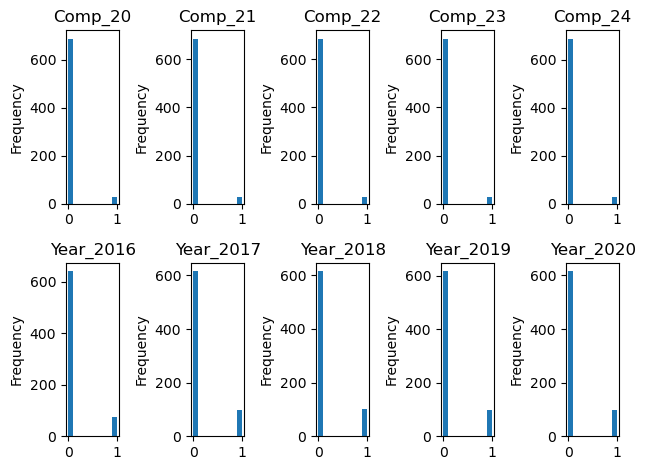

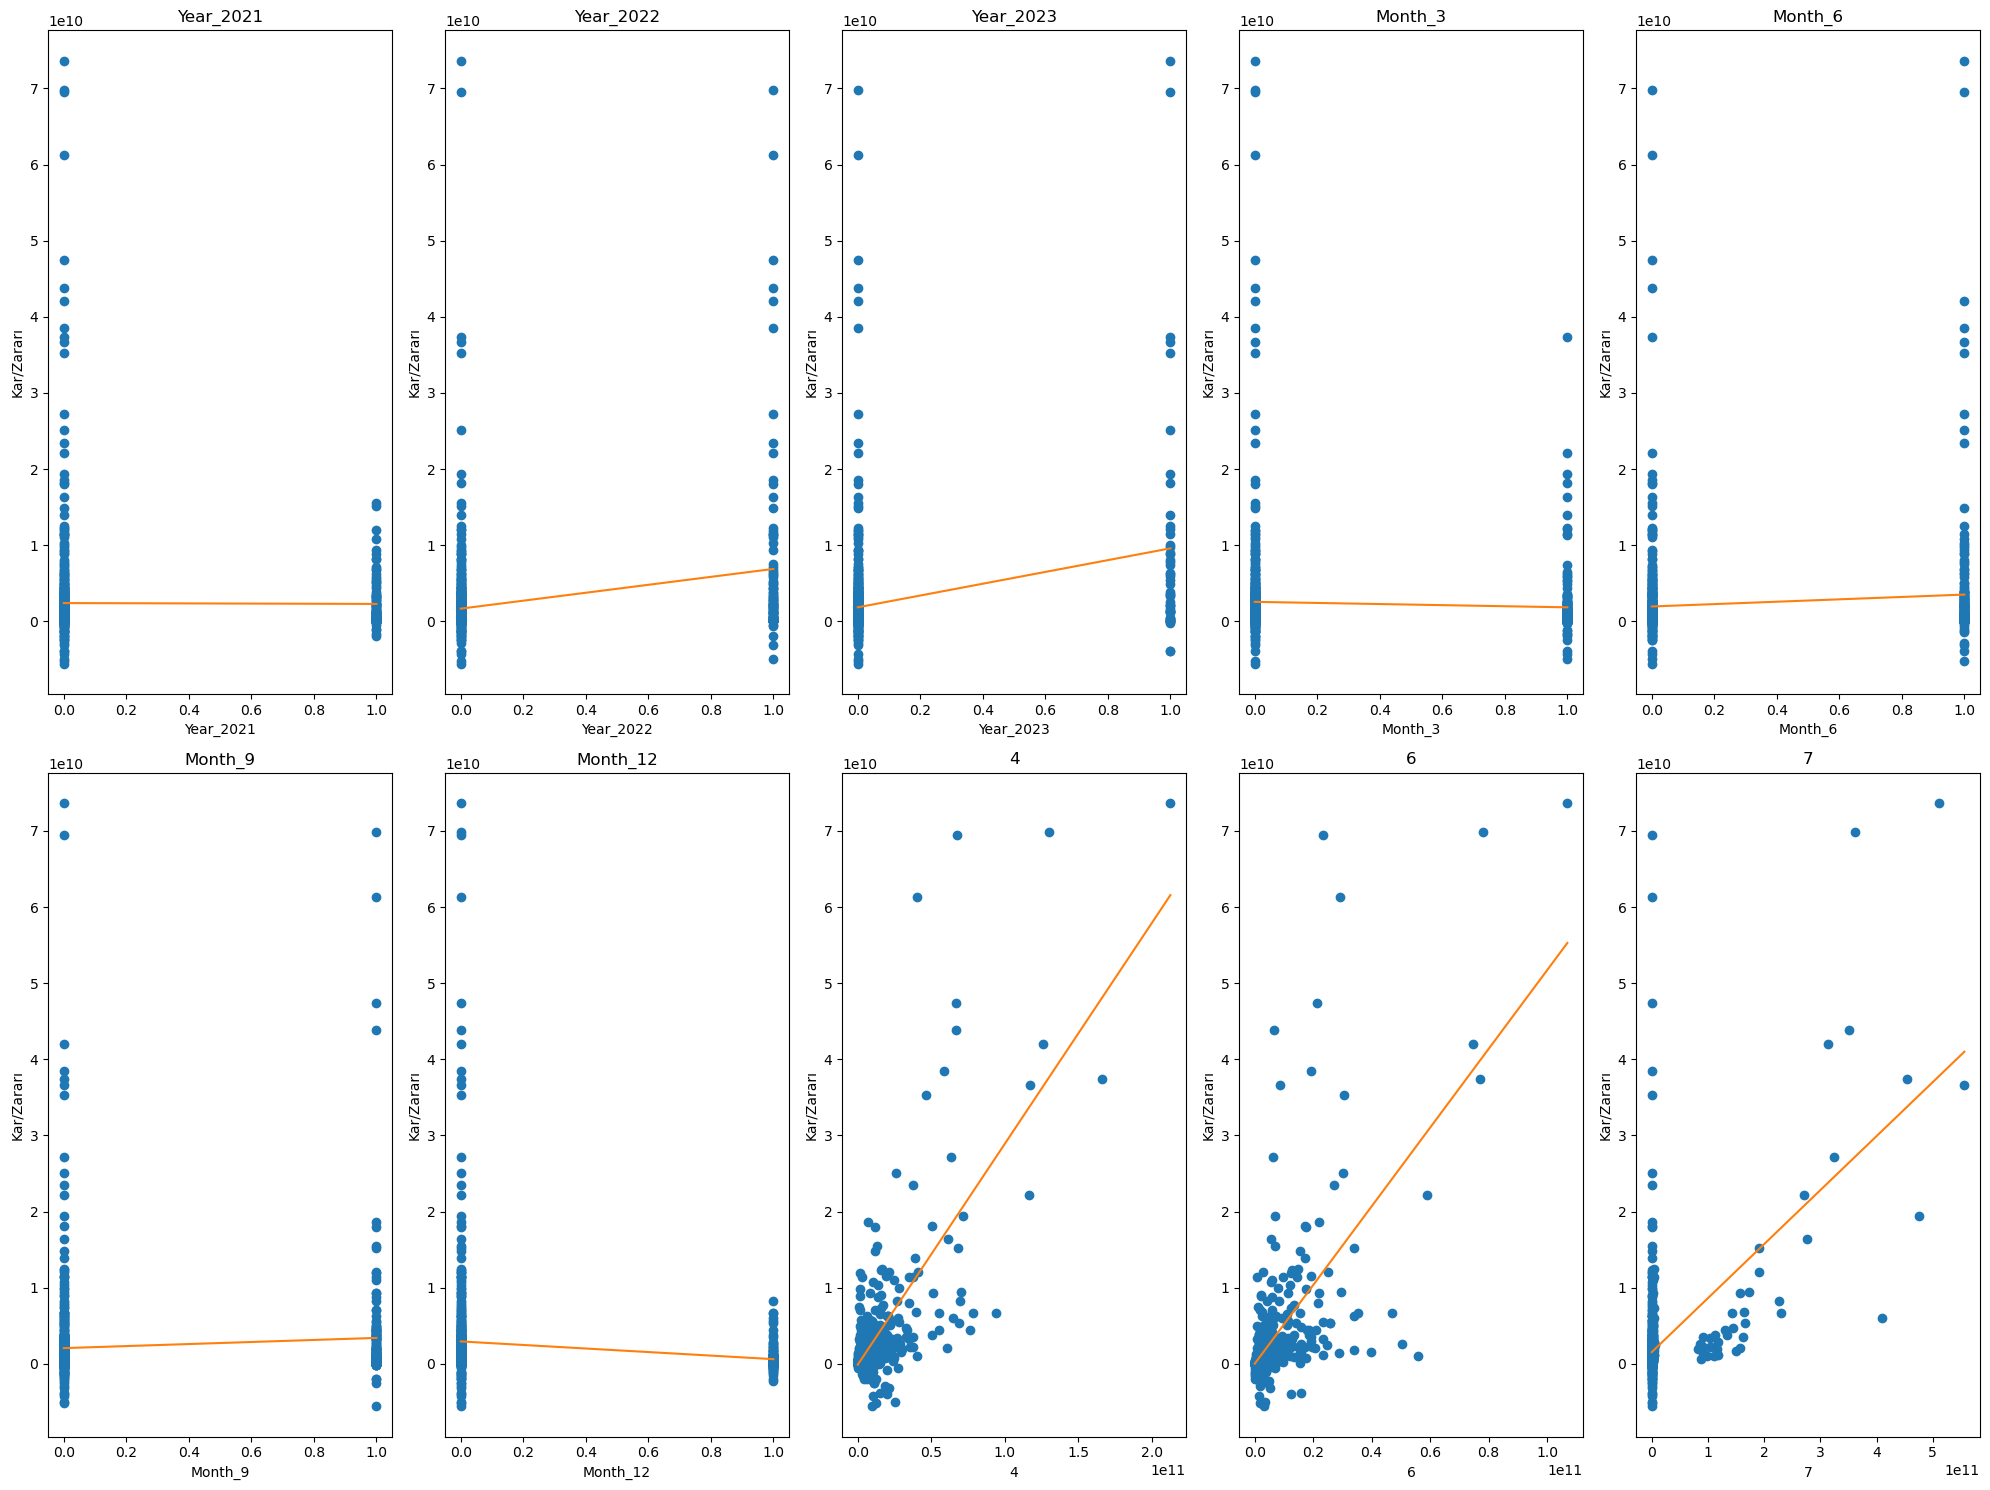

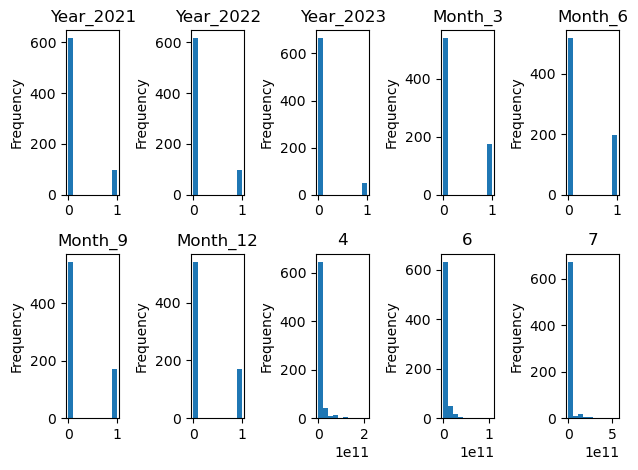

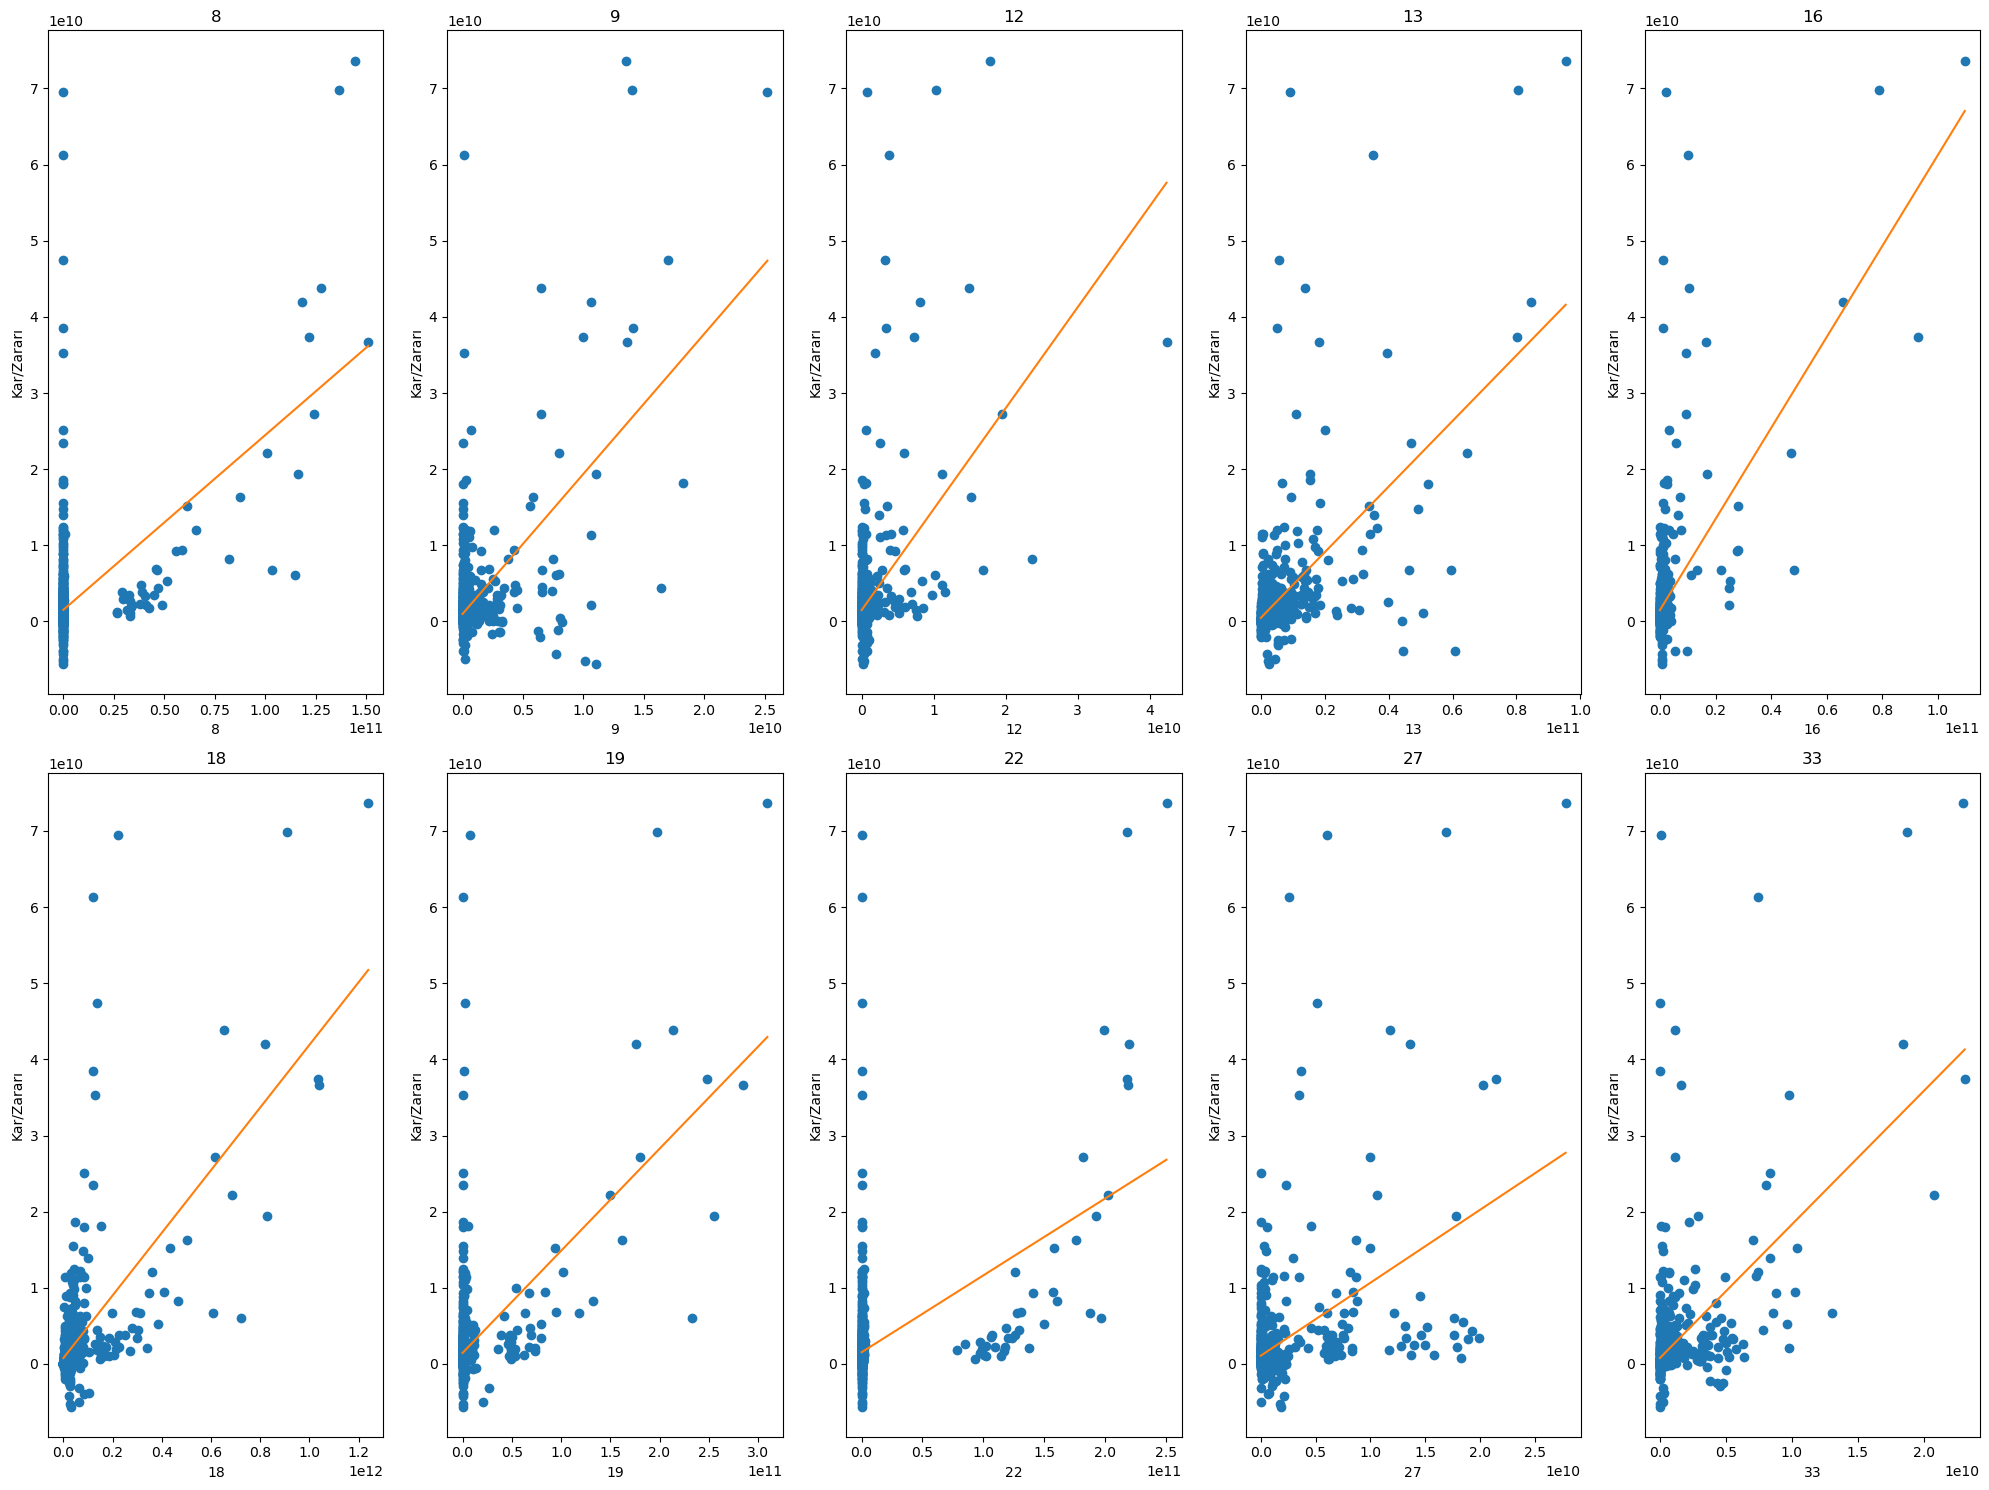

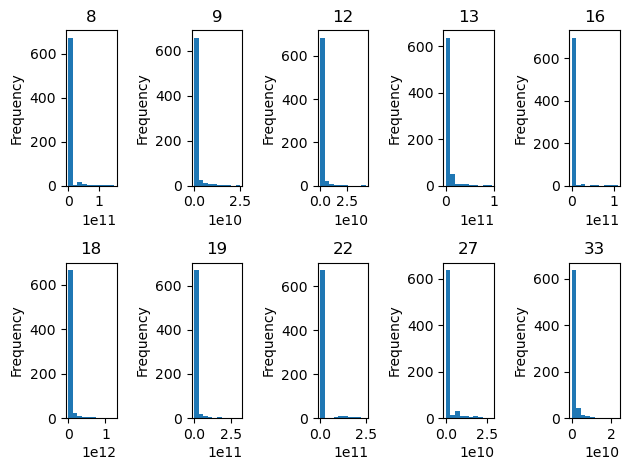

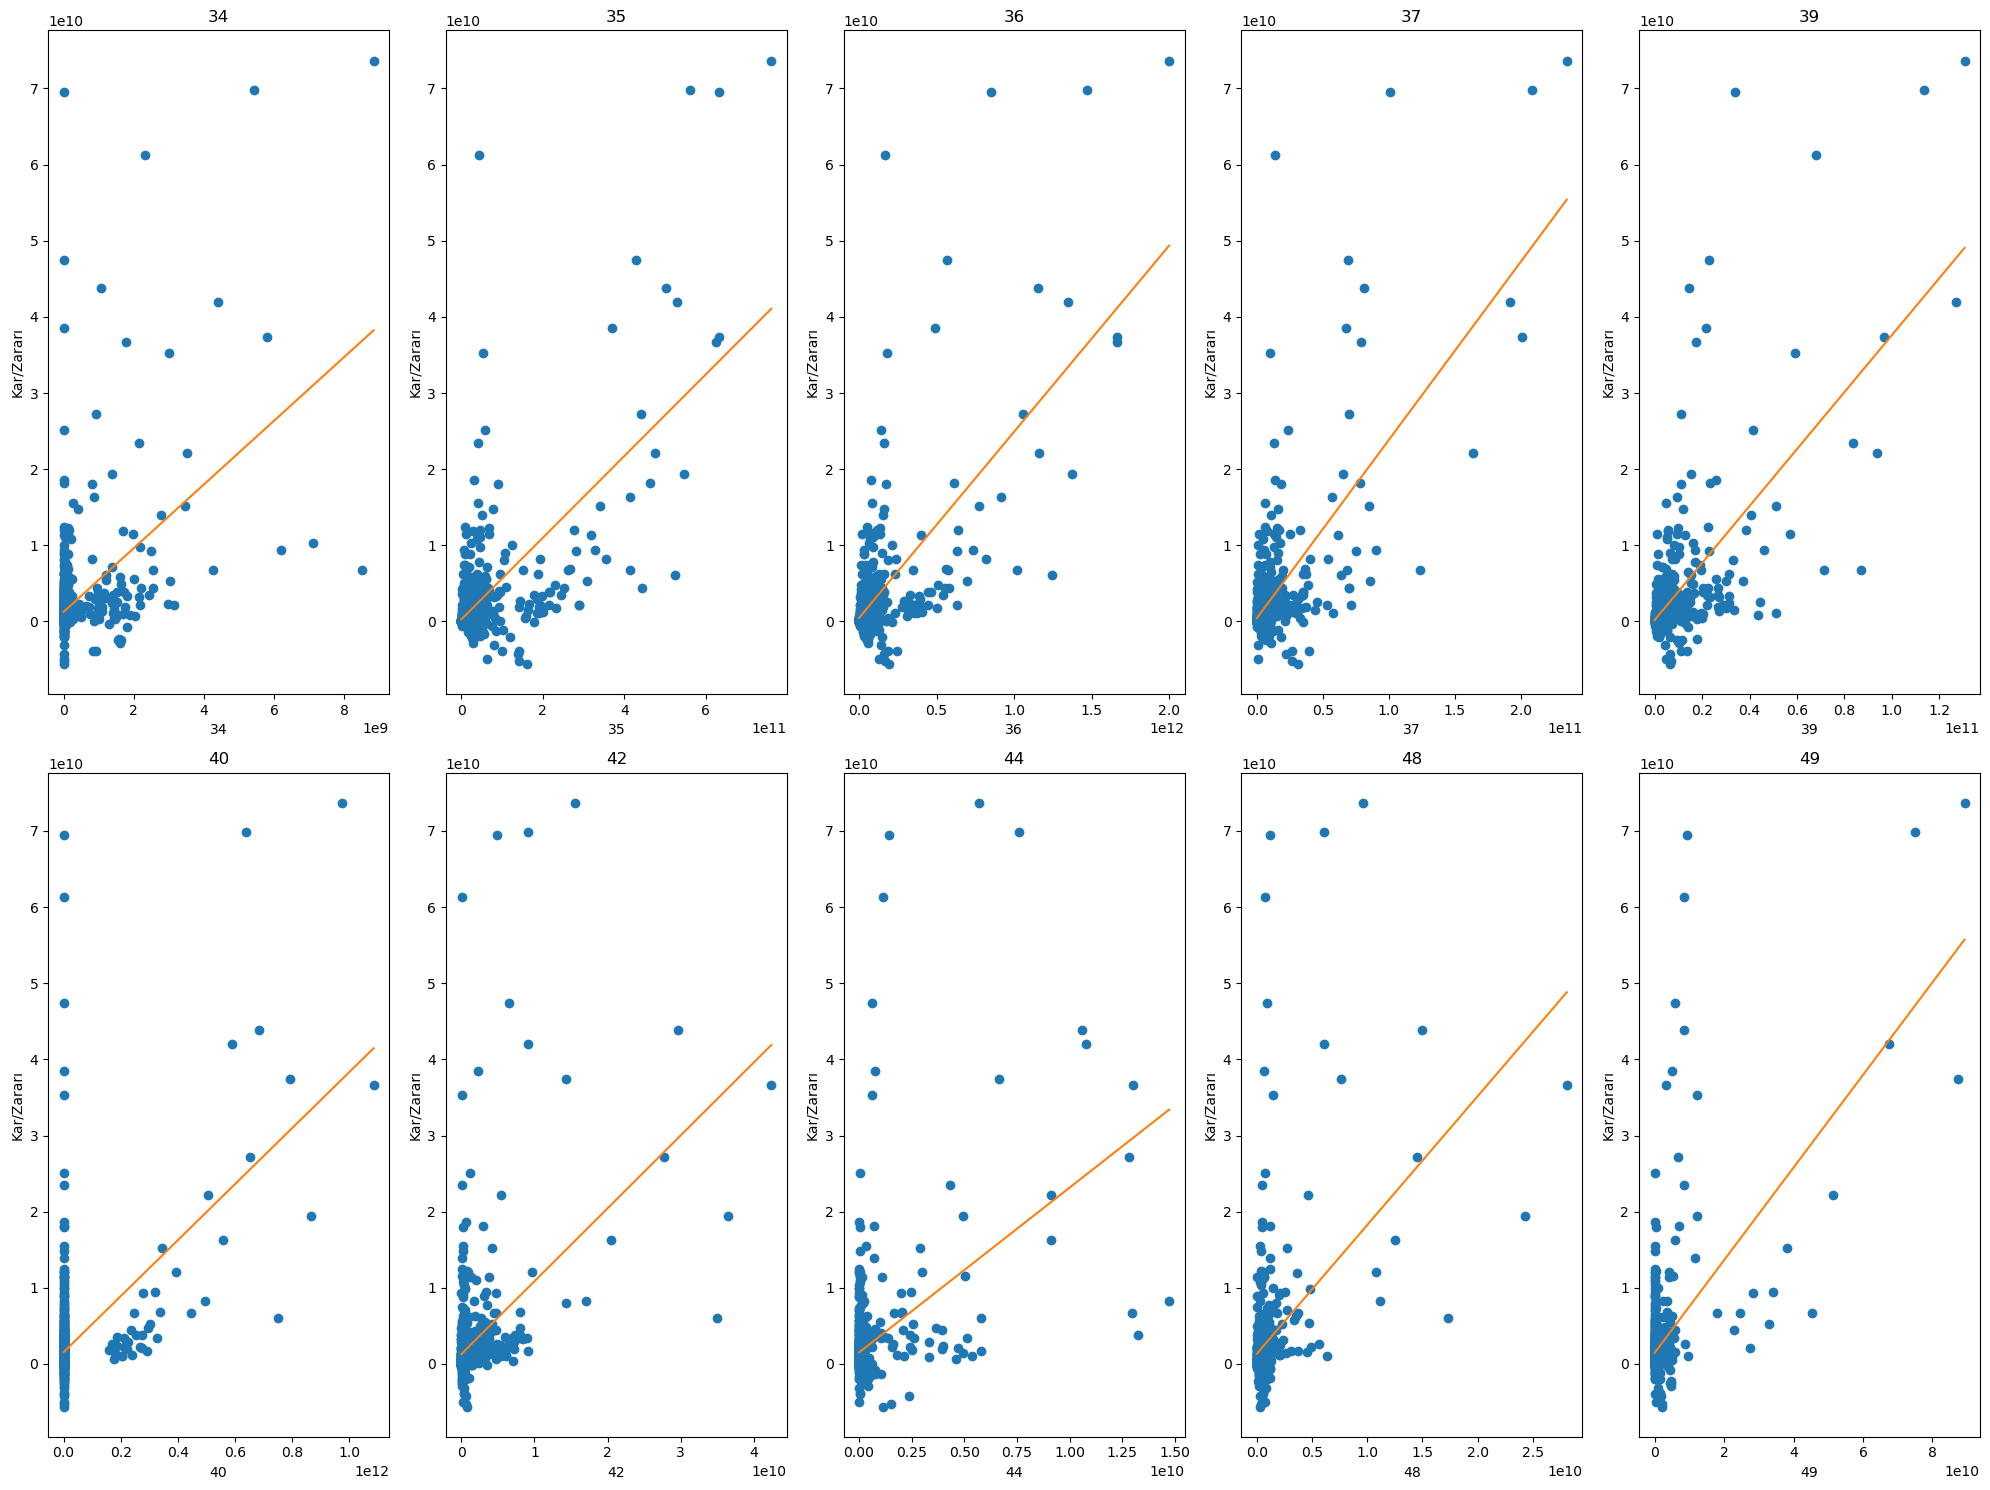

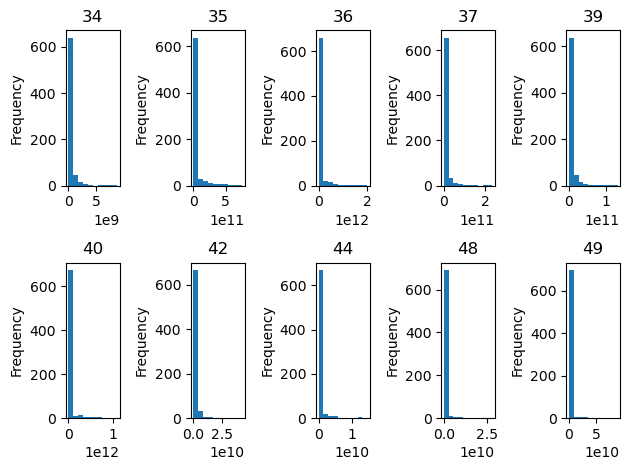

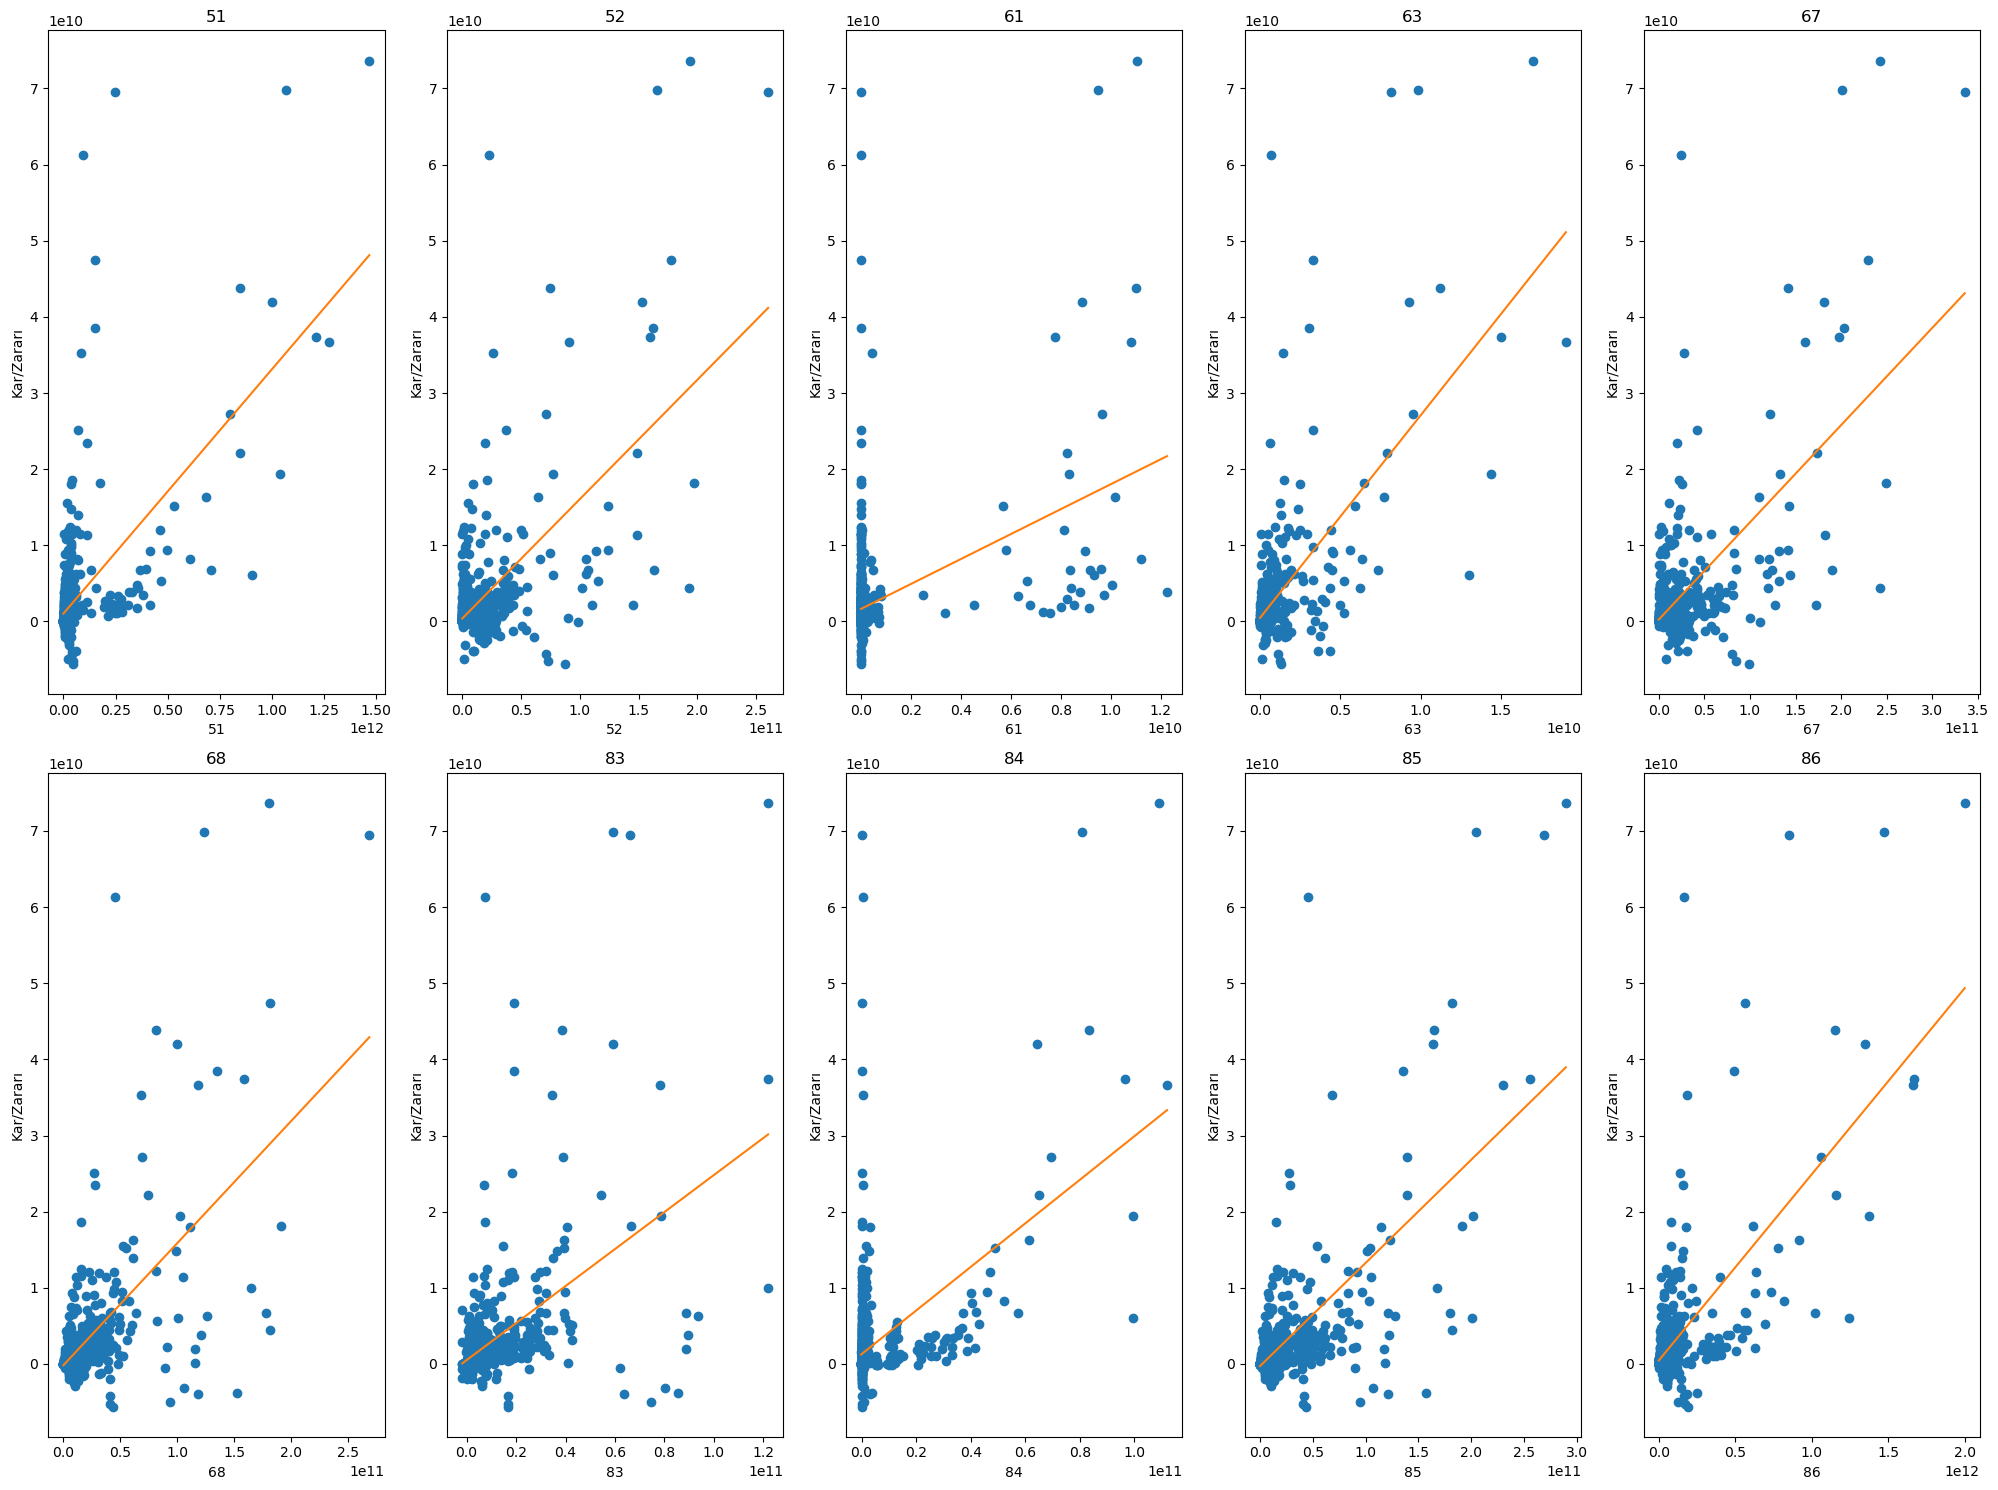

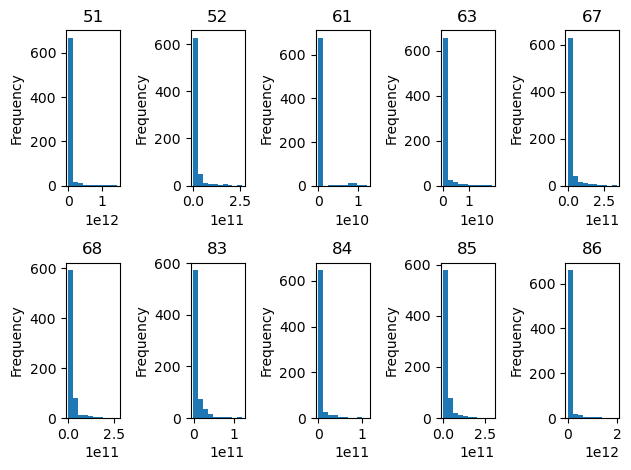

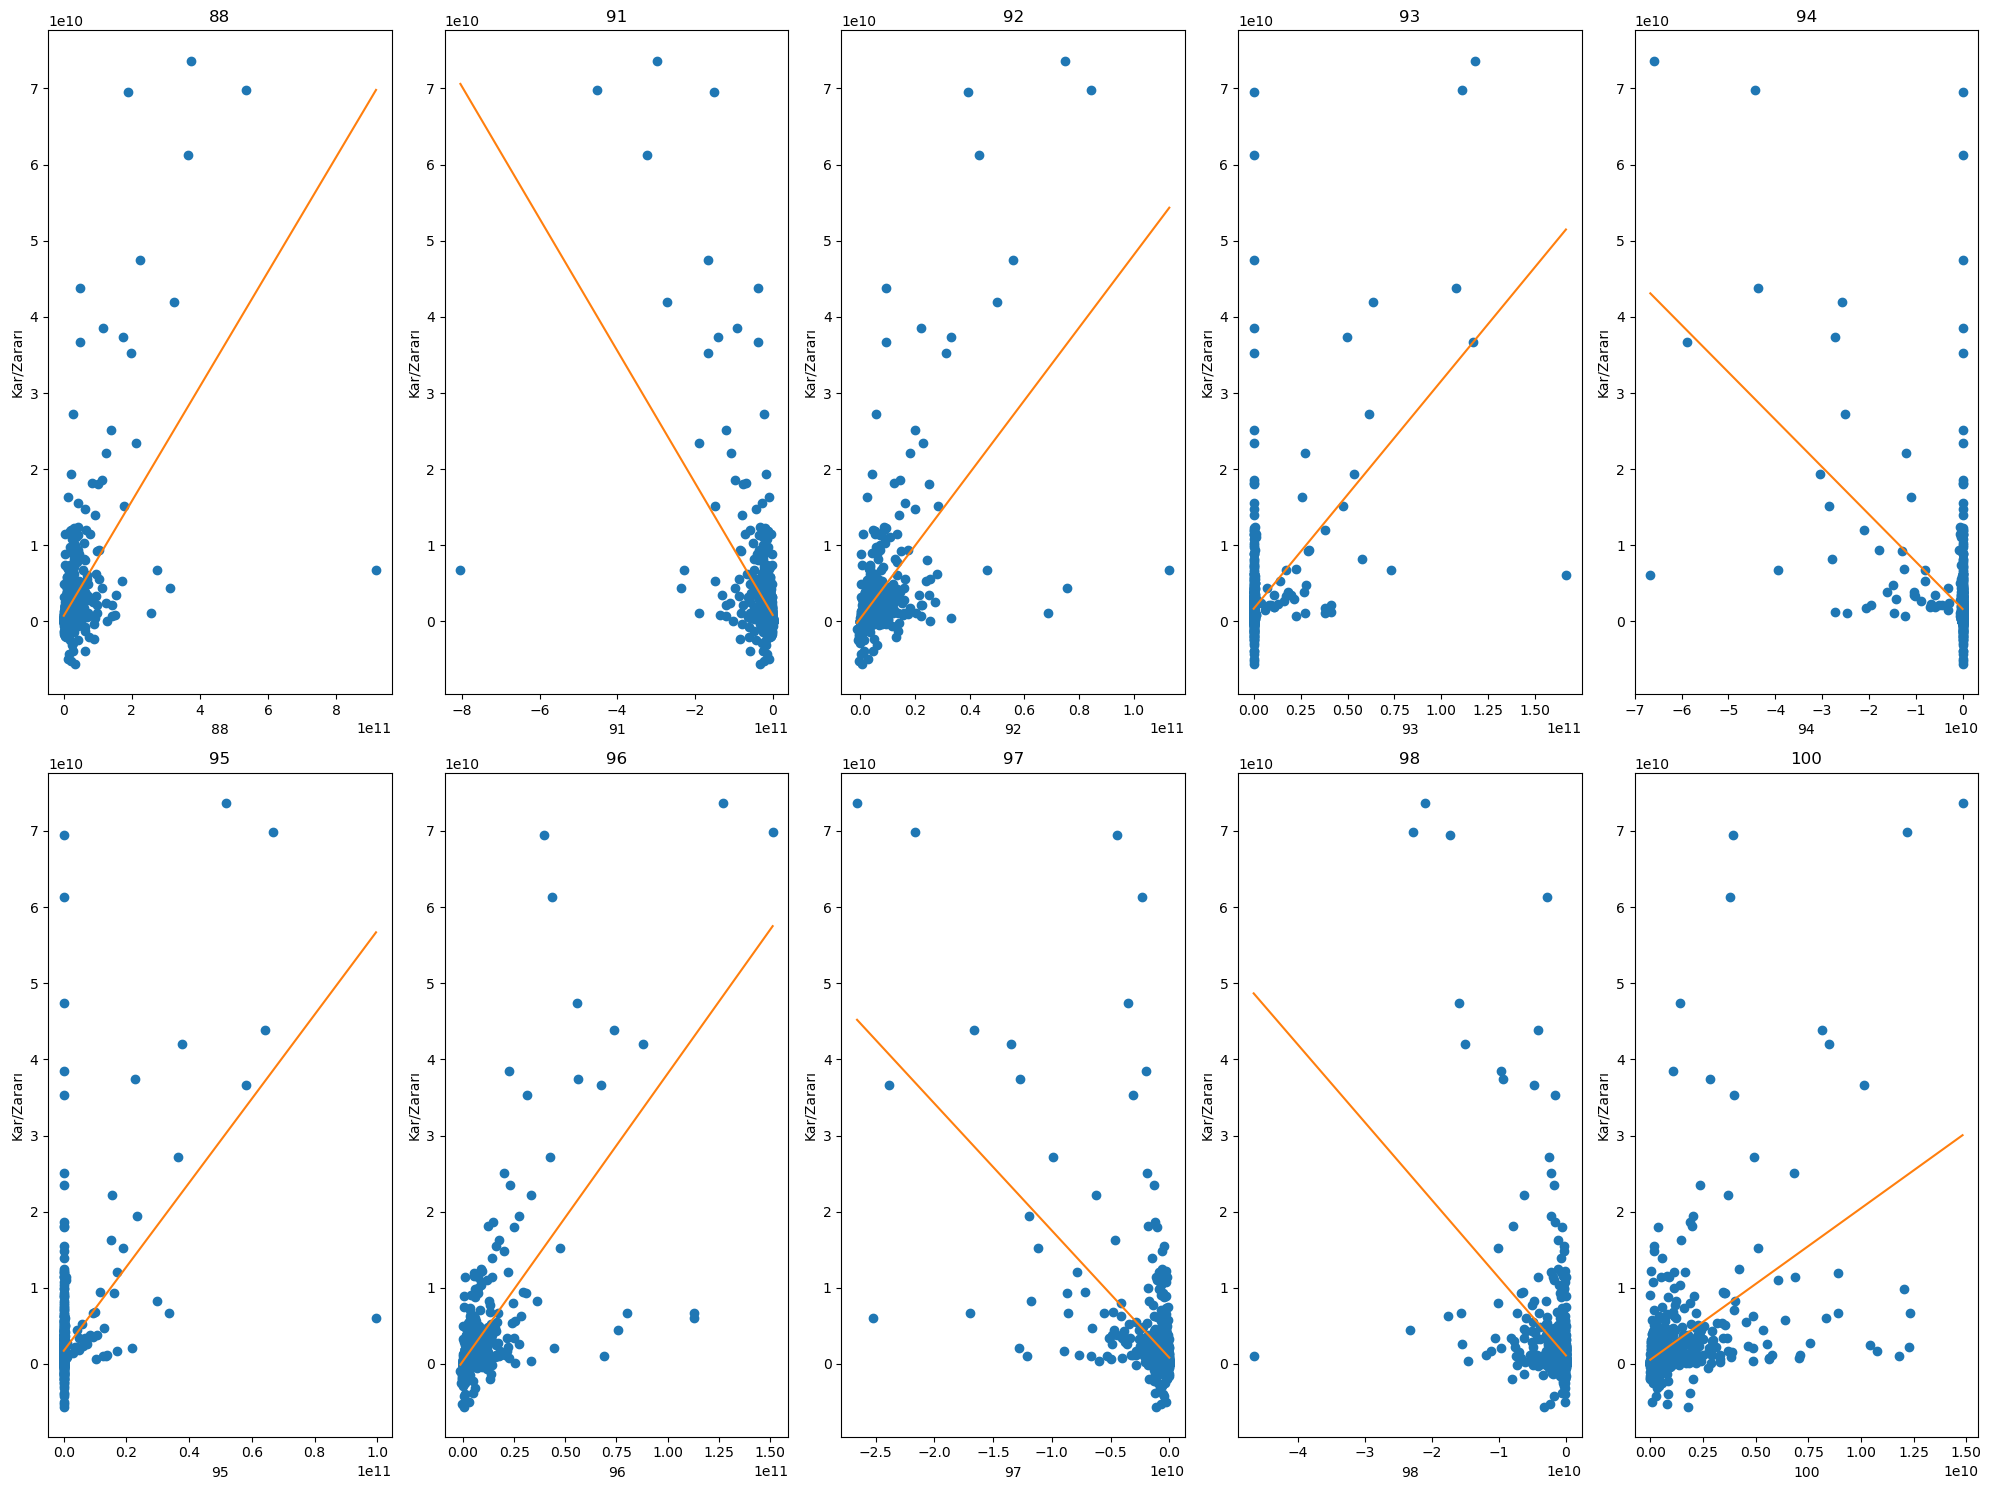

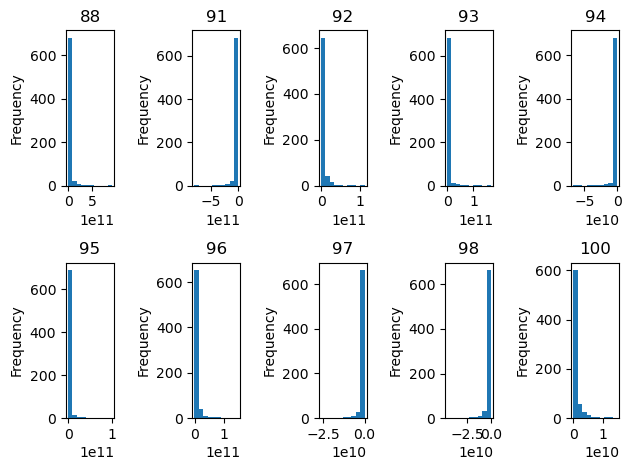

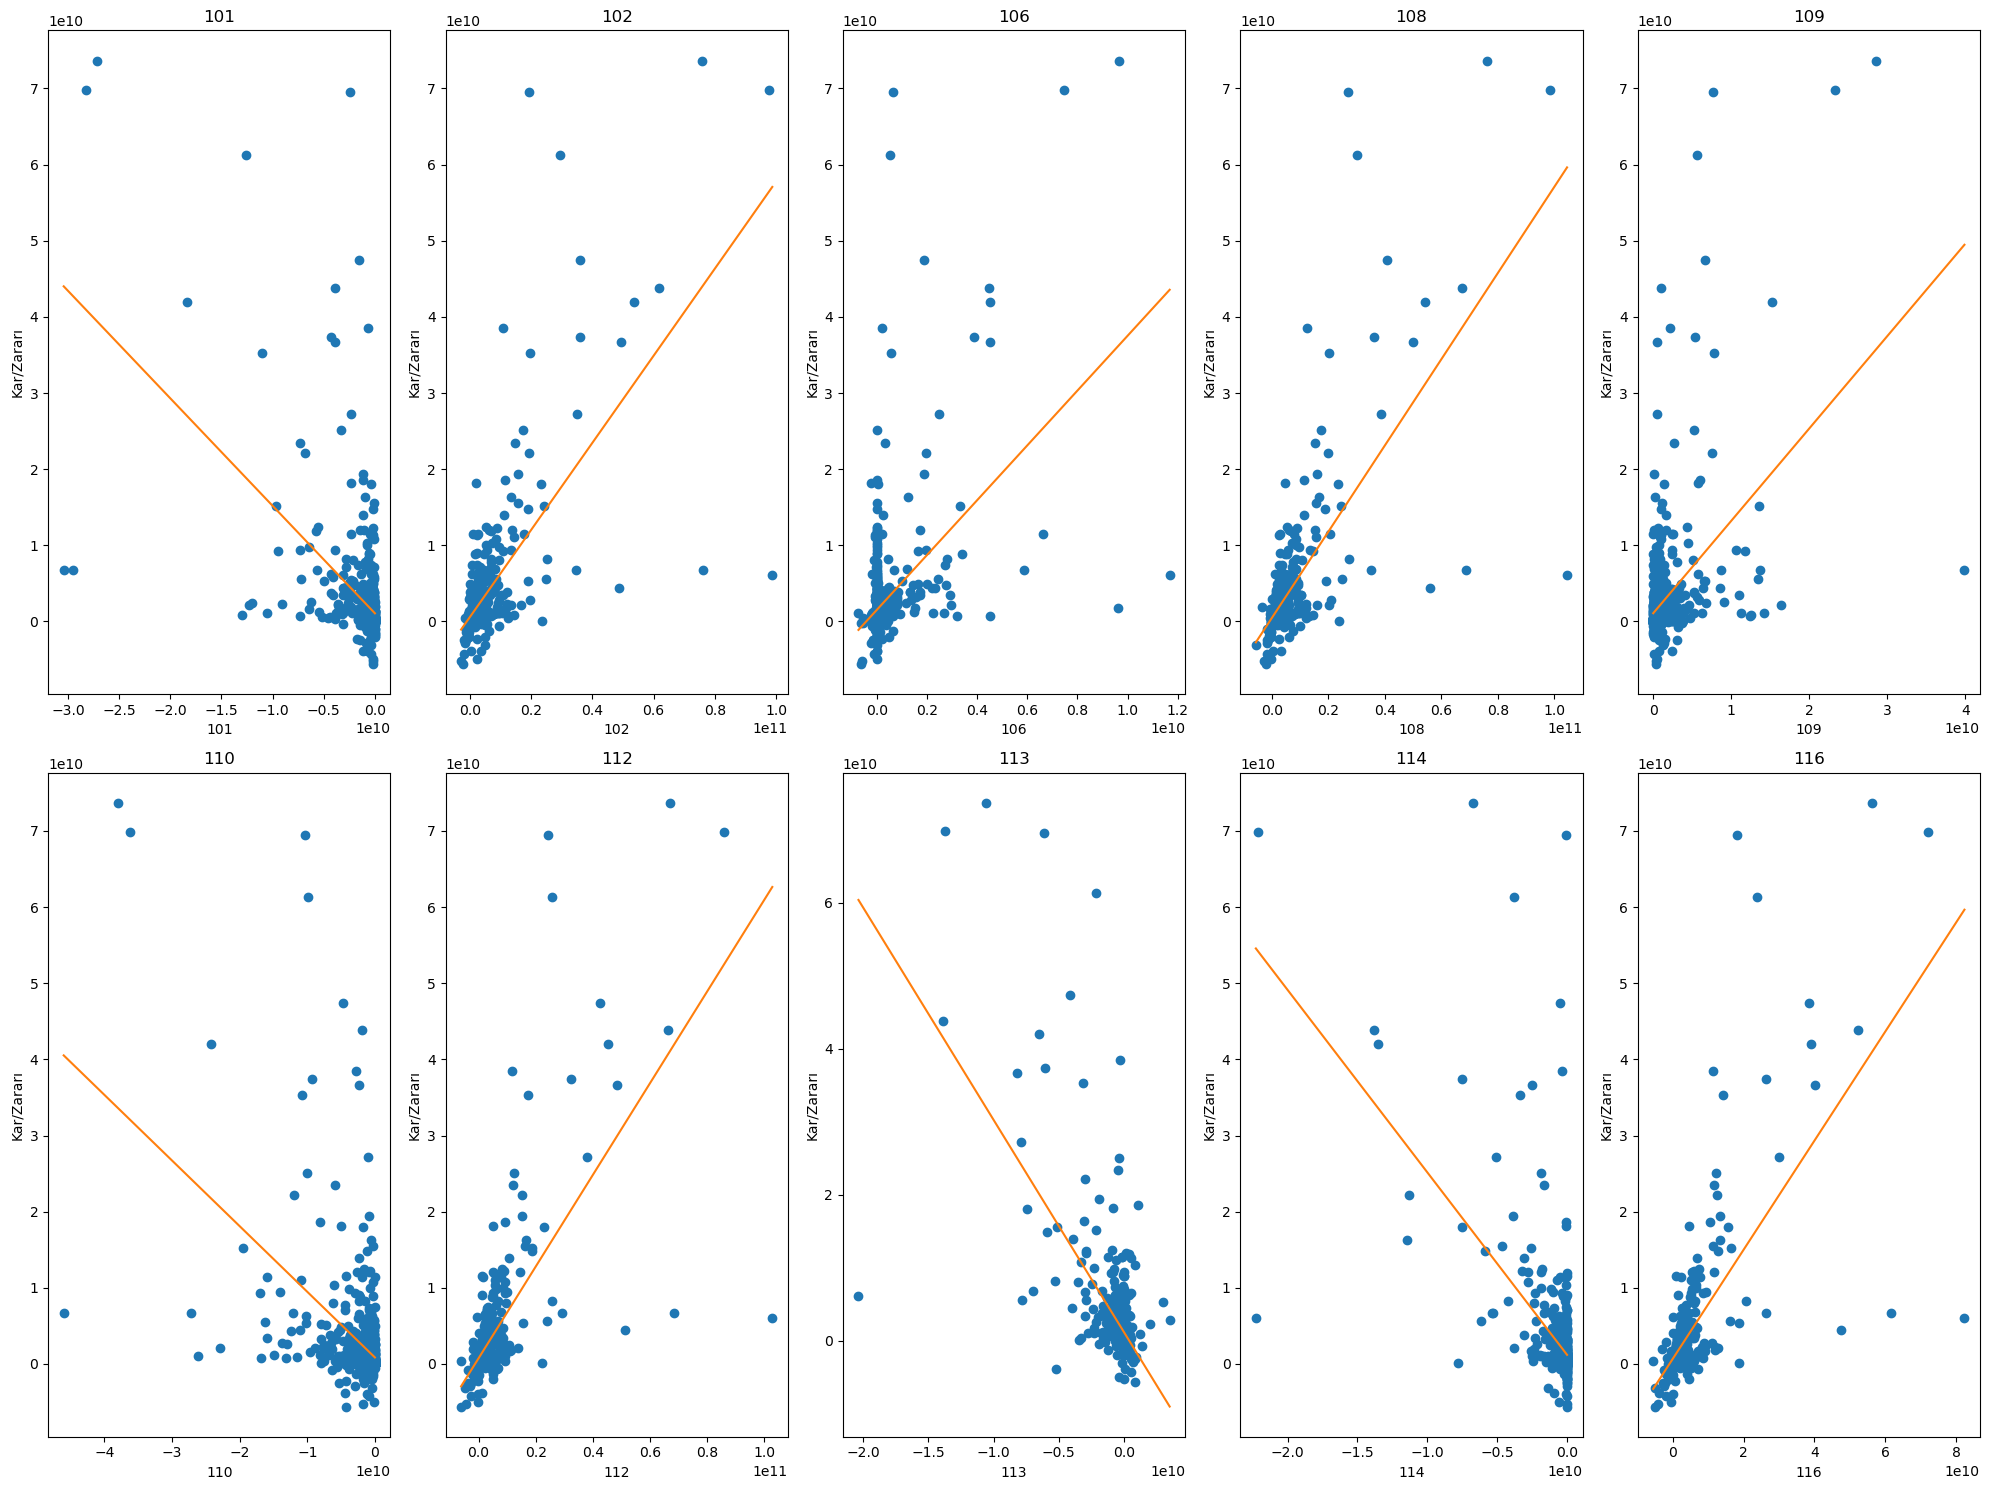

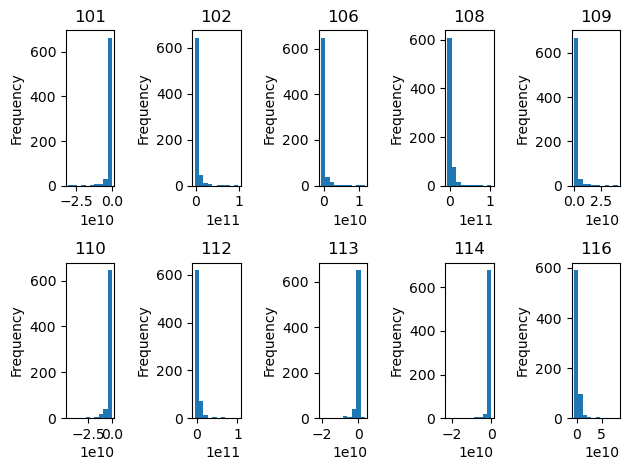

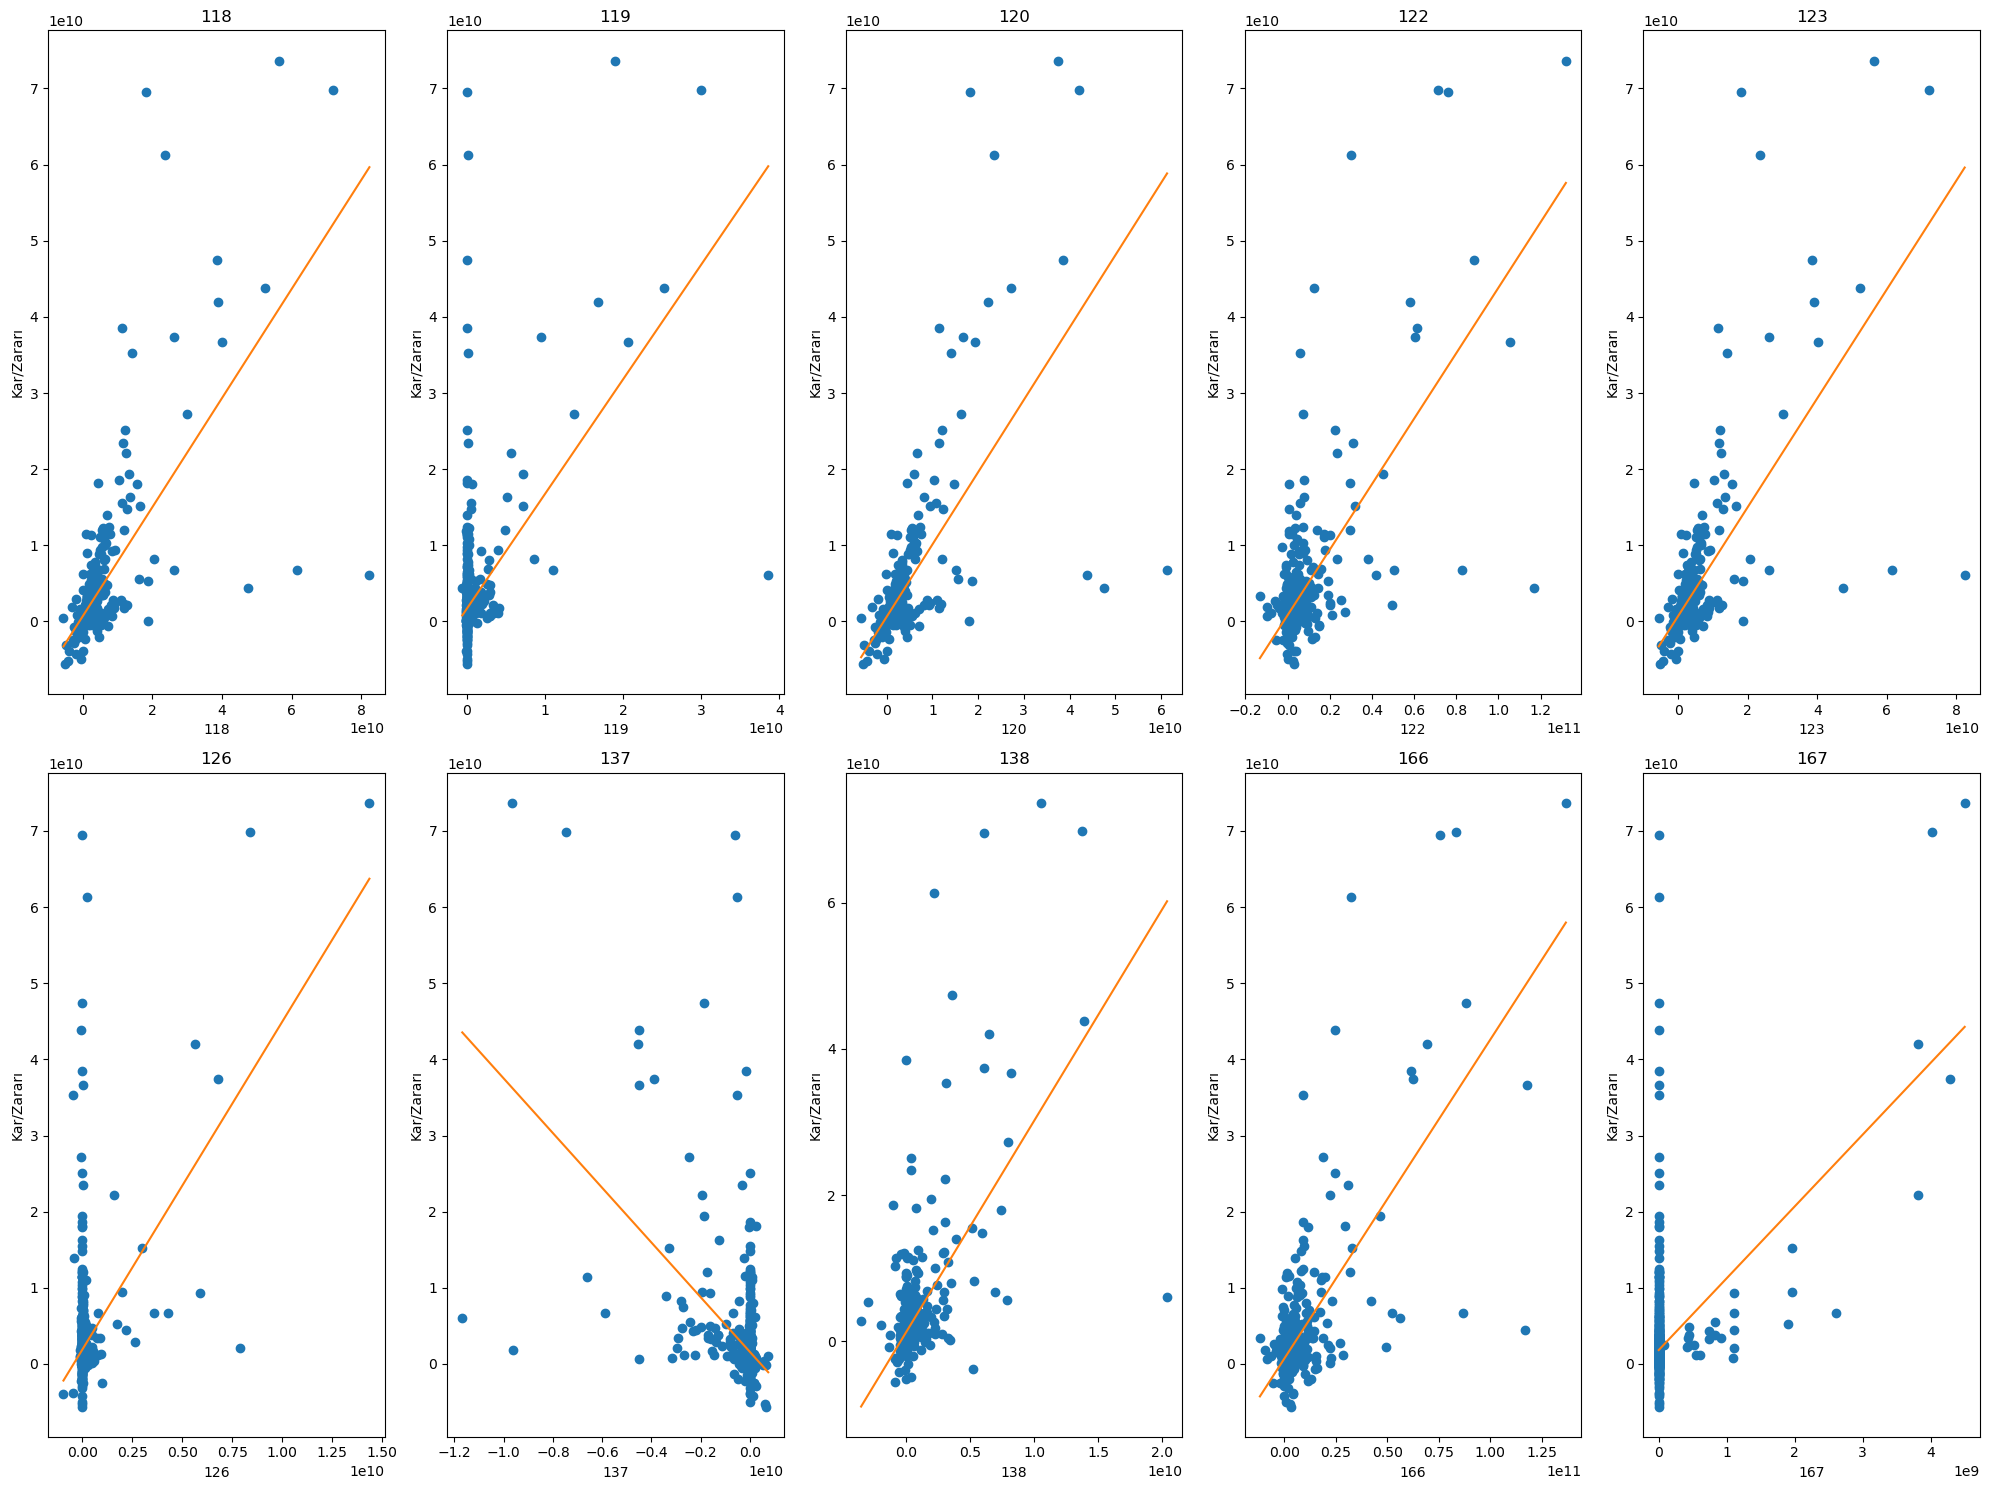

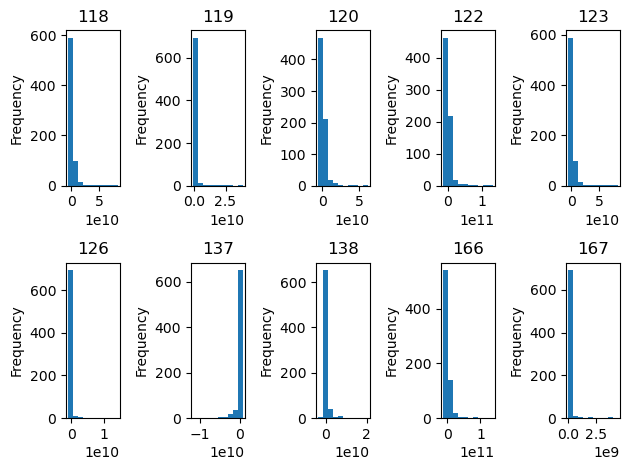

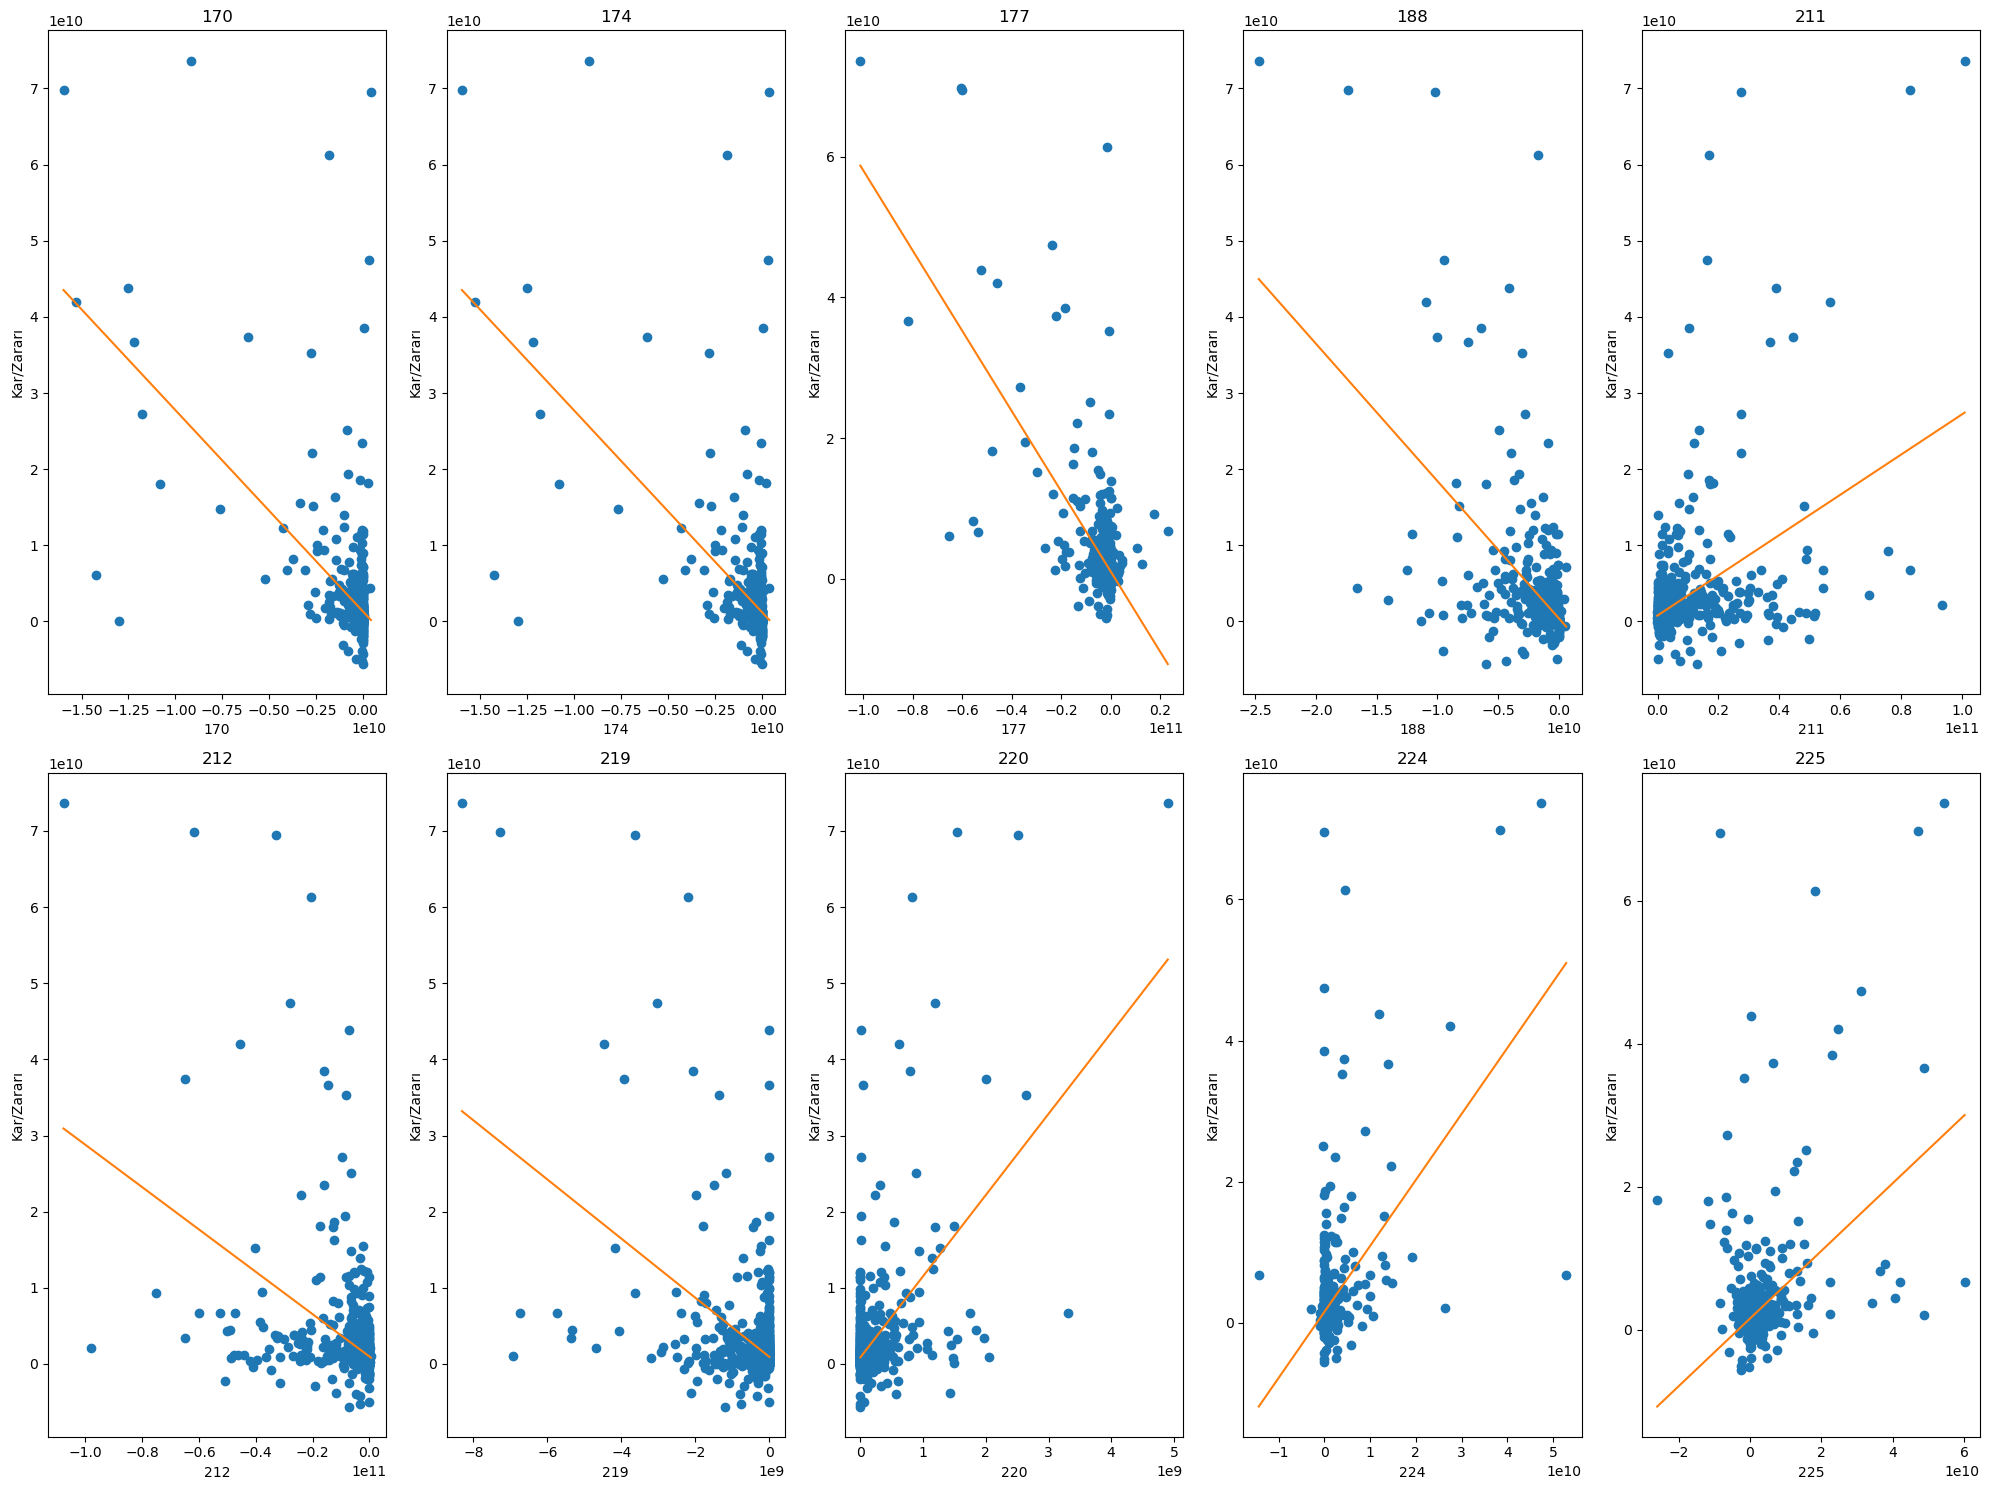

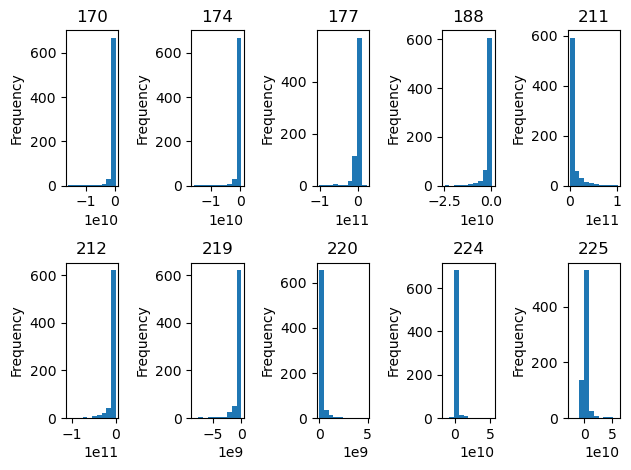

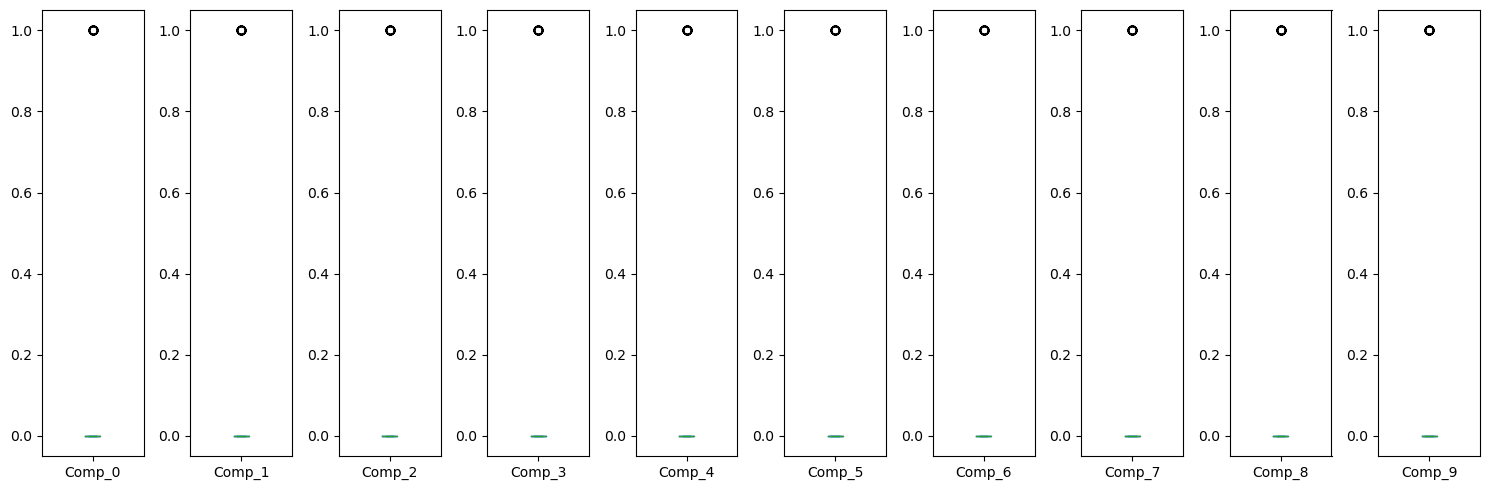

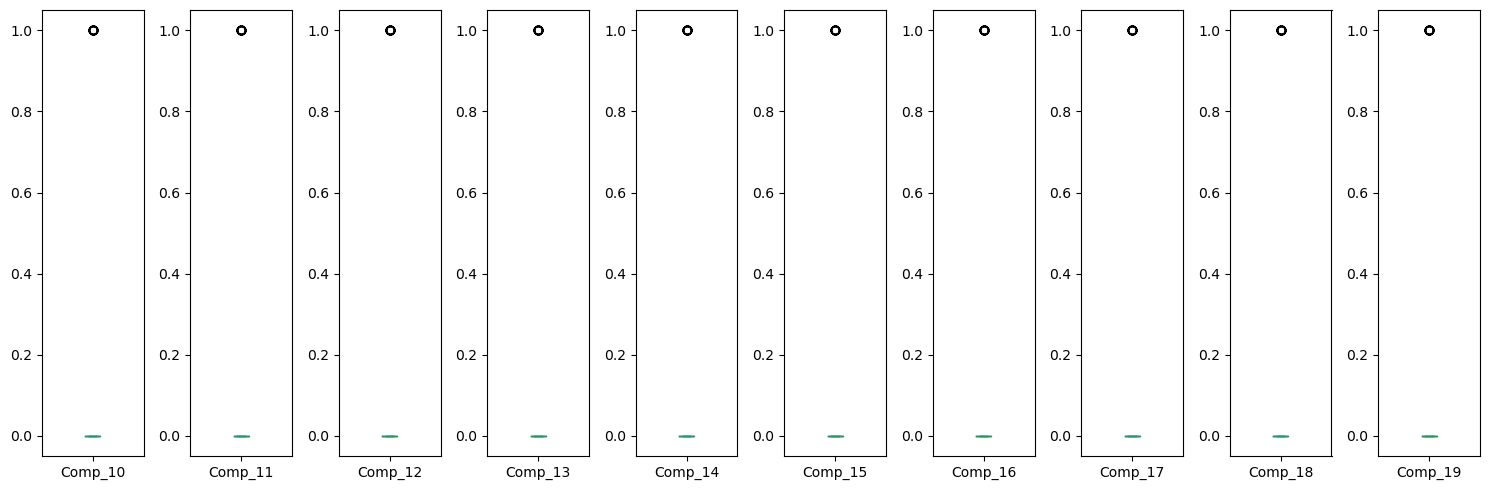

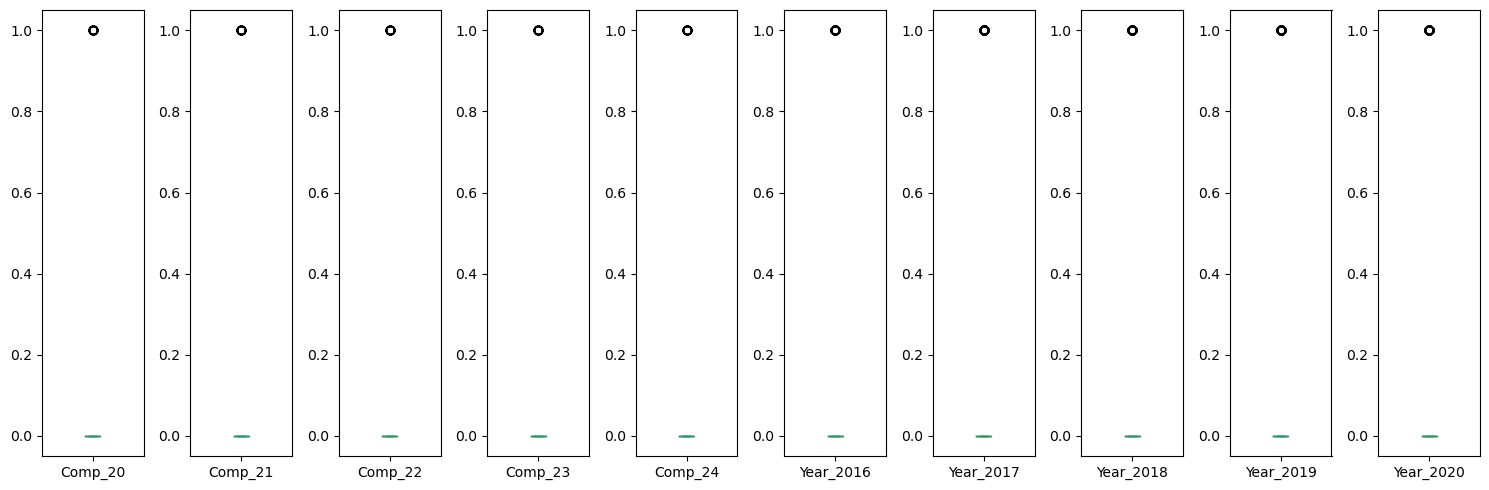

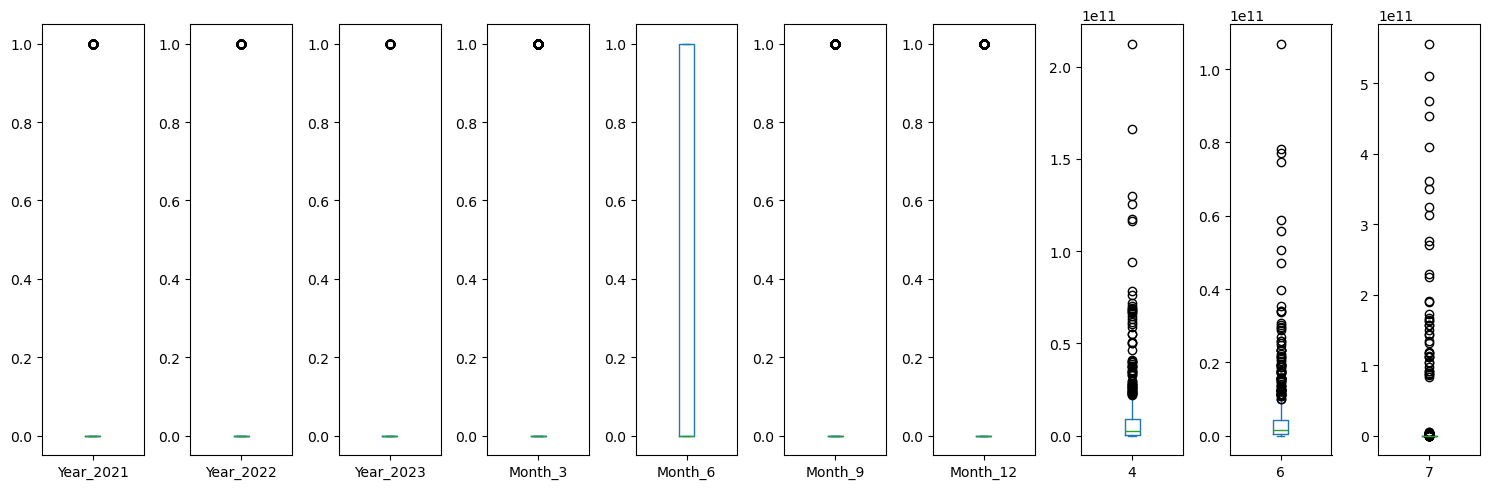

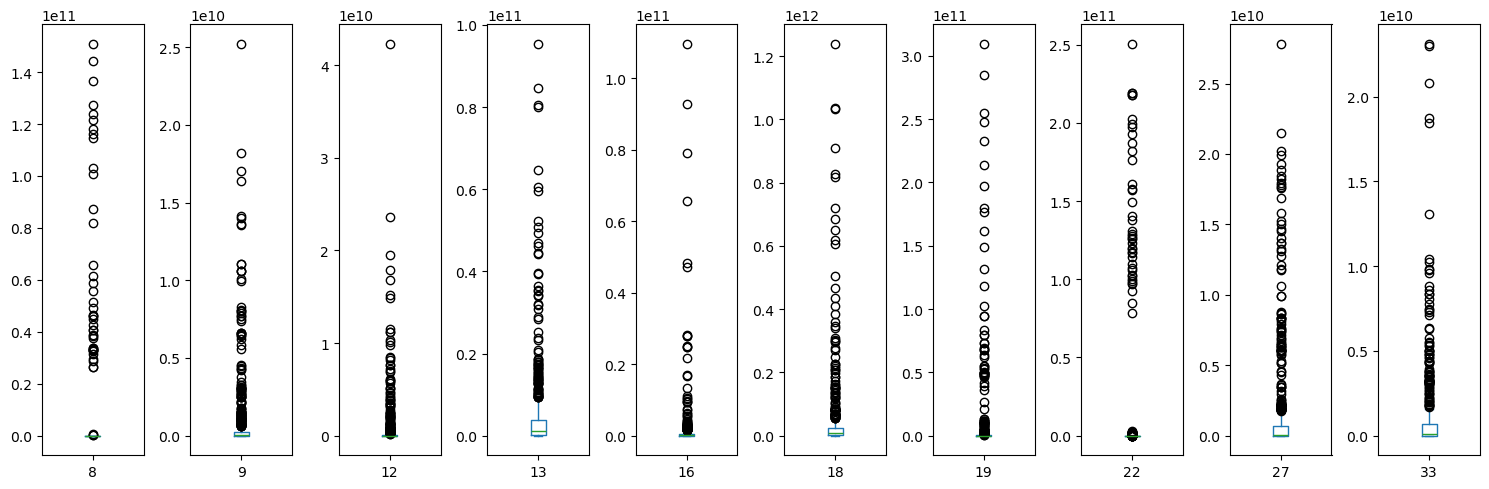

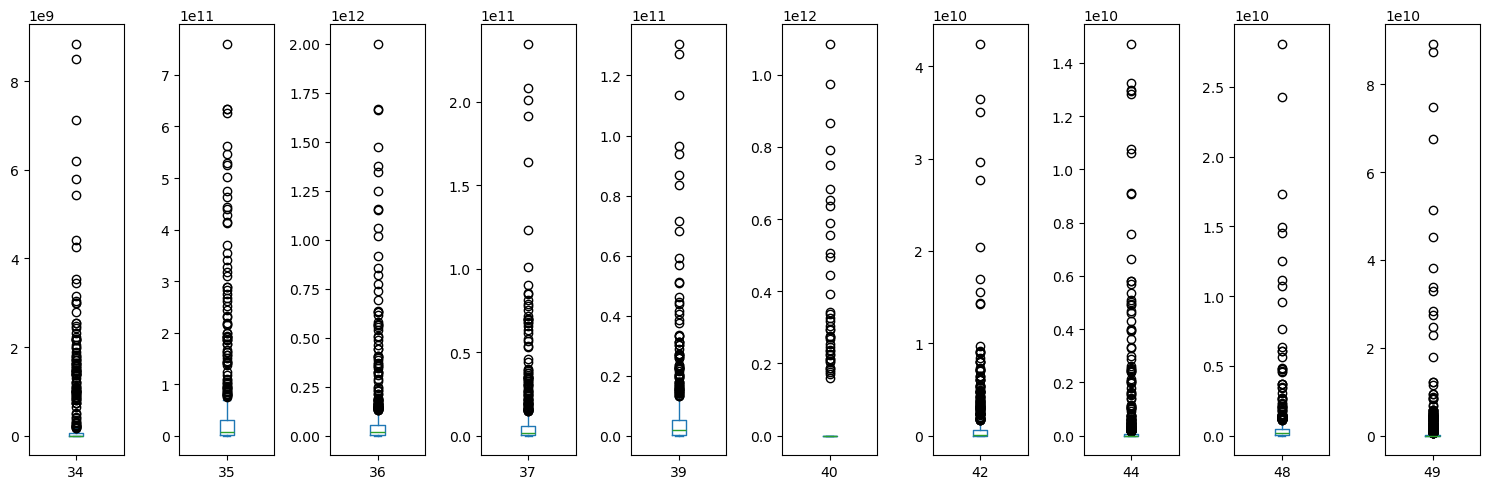

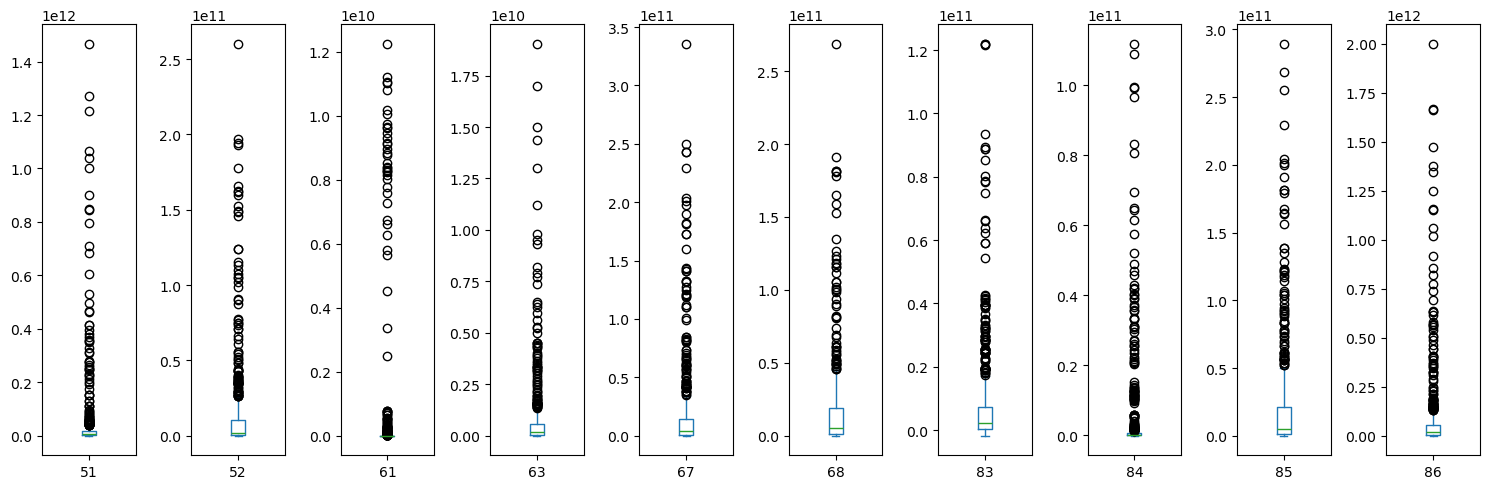

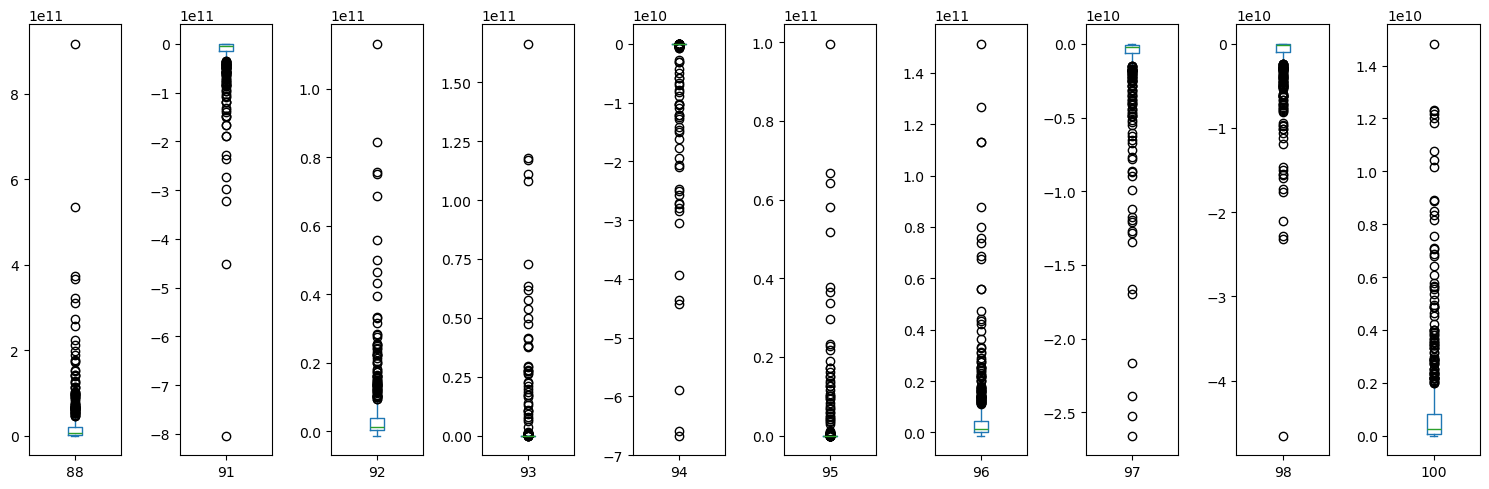

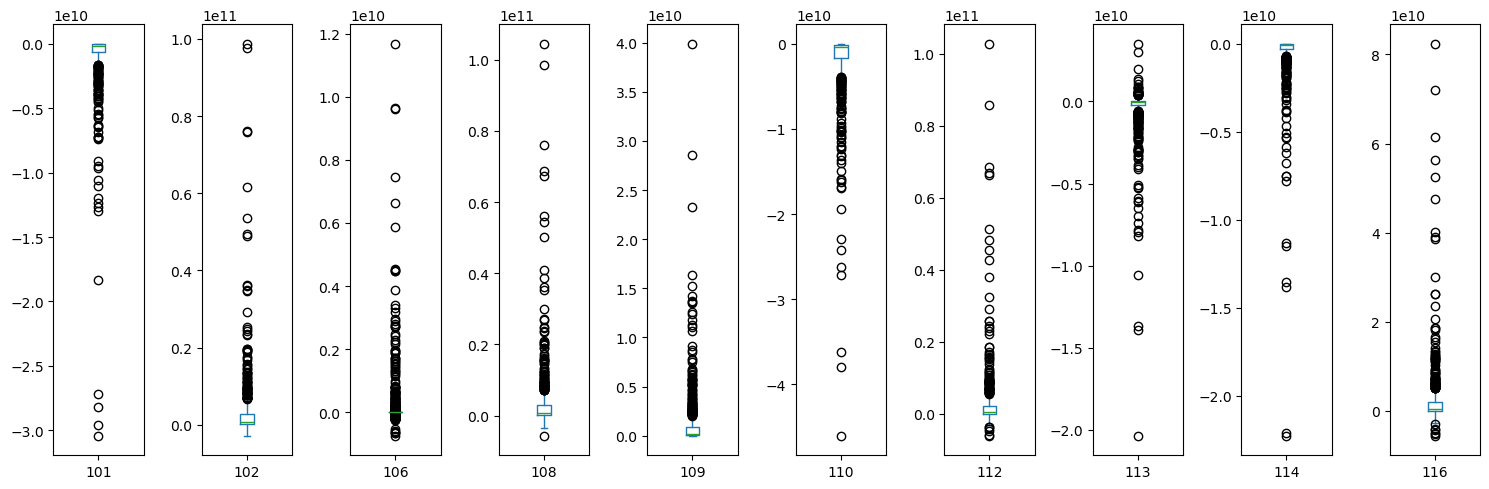

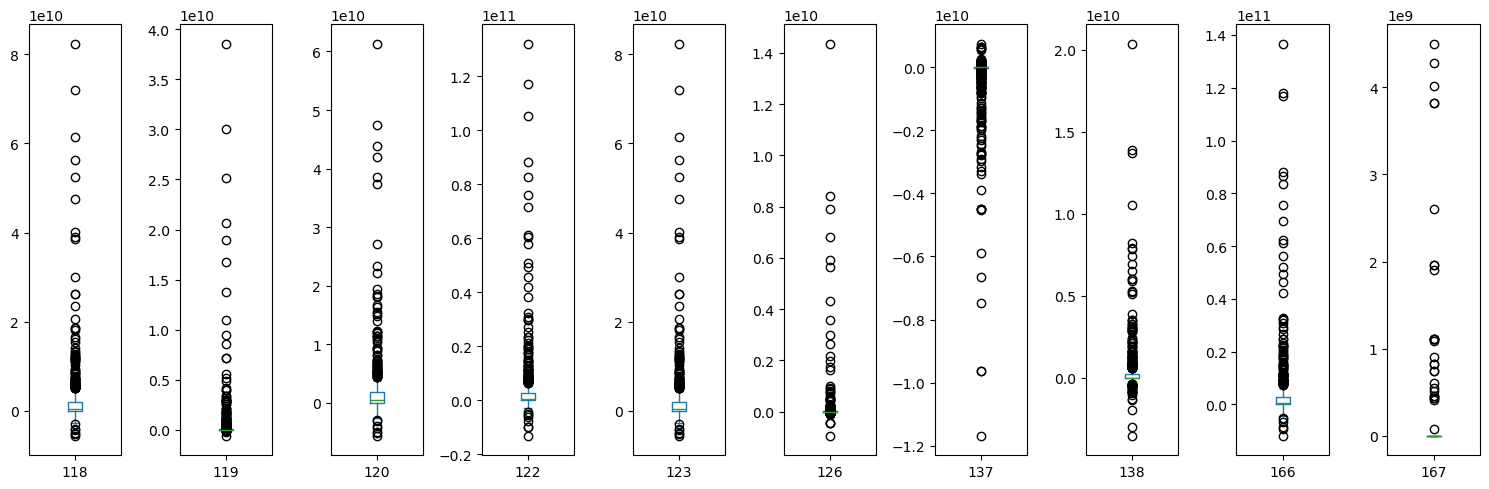

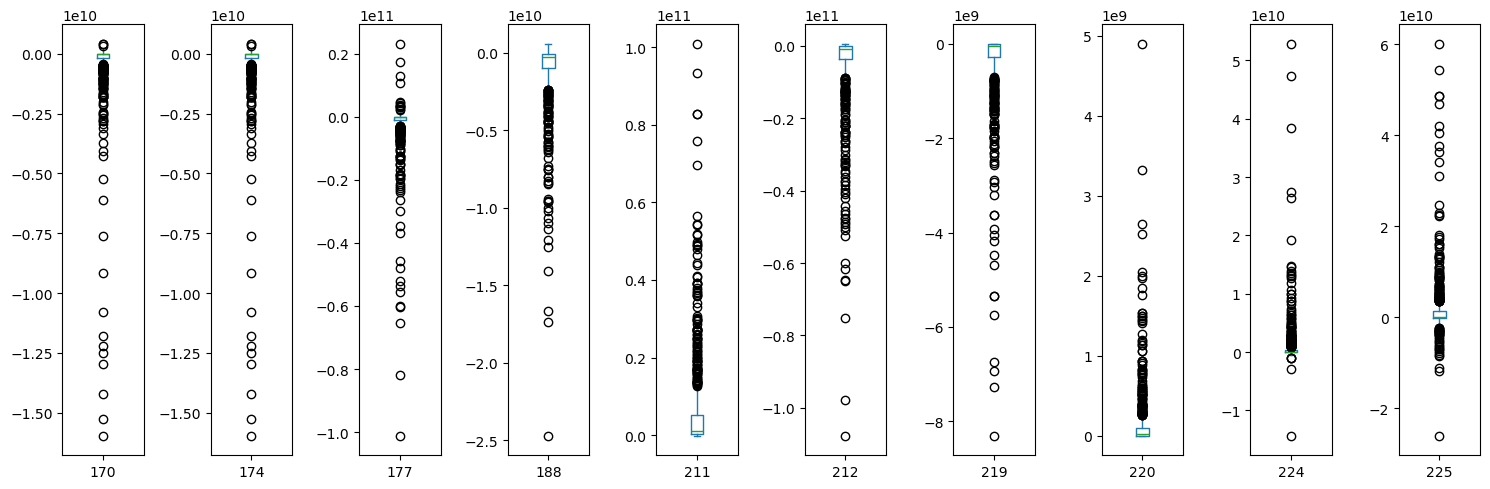

was saved firm_value_edited.csv 
LR CV - r2score :  -2.5734556495491754
LR test-r2score :  0.7976237374391385
LR      : 0.10257863998413086 sec

gaus CV - r2score :  -0.2045431509101336
gaus test-r2score :  -0.0790251541461375
gaus    : 1.065384864807129 sec

ridge CV - r2score :  -1.7925733251579128
ridge test-r2score :  0.7782310657105171
ridge   : 0.2977569103240967 sec

LASSO CV - r2score :  -2.2910237285379269
LASSO test-r2score :  0.7563761165396911
LASSO   : 1.215794324874878 sec

EN CV - r2score :  0.2427094967975020
EN test-r2score :  0.7208186335303990
EN      : 0.1099846363067627 sec

KNN CV - r2score :  0.3772678171718810
KNN test-r2score :  0.6246088730756567
KNN     : 0.7536666393280029 sec

DT CV - r2score :  0.6799752808479498
DT test-r2score :  0.8120615322210145
DT      : 0.28572654724121094 sec

ExtraT CV - r2score :  0.7199583956926834
ExtraT test-r2score :  0.8923744325472047
ExtraT  : 3.868093490600586 sec

Ada CV - r2score :  0.4357288182049436
Ada test-r2score :

  File "C:\Users\ilker\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


lgb CV - r2score :  0.2904405017606616
lgb test-r2score :  0.7102483752396317
lgb     : 1.3978376388549805 sec

catb CV - r2score :  0.6746375269554961
catb test-r2score :  0.7362330319926549
catb    : 63.59076499938965 sec

model time:120.262042760849 sec

best dependOnTest:  ANN-lbfgs
Test set r2 score (best model): 0.9249901348672693

Evaluation metric scores for best model which is ANN-lbfgs:
Test set r2: 0.9249901348672693
Test set MSE (Mean Squared Error): 4.722420501452813e+18
Test set MAE (Mean Absolute Error): 856578944.1549823
Best model: ANN-lbfgs


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 11 23:49:58 2024

@author: ilker
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import ARDRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import time
import statsmodels.api as sm

from sklearn.impute import KNNImputer

datas=pd.read_csv('BalanceSheetDataSet.csv')


datas_column_names = list(datas.columns)
datas = datas.iloc[::-1]


#Since there is a problem with the names appearing, I gave numbers like 0,1,2,3.
new_column_names = [str(i) for i in range(len(datas.columns))]
datas.columns = new_column_names

#timeSeries----------------------------------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(datas.iloc[0:24,3].index, datas.iloc[0:24,3], label='Net Dönem KarZarar-Output')
plt.plot(datas.iloc[0:24,3].index, datas.iloc[0:24,4], label='nakit nakit benzerleri-4column')
plt.plot(datas.iloc[0:24,3].index, datas.iloc[0:24,6], label='6column')
plt.xlabel('index')
plt.ylabel('Değer')
plt.title('4and6cloums')
plt.legend()
plt.grid(True)
plt.show()



#where line is  they changed
changing=[]
for line in range(1,len(datas)):
            if not (datas.iloc[line,0] == (datas.iloc[line - 1,0])):#2
              changing.append(line)

#sm for every comp col4
temp=0
df_dict = {}
for line in changing:
    res_spec = sm.tsa.seasonal_decompose(datas.iloc[temp:line,4], model='additive', period=4)
    
    if line < 100 :
        res_spec.plot()
        
    res_spec_df = pd.concat([res_spec.trend, res_spec.seasonal,res_spec.resid],axis=1)


    df_dict[f'{line}_df'] = res_spec_df
    temp=line
    
time_res_df = pd.concat([df for df in df_dict.values()], axis=0)
time_res_df = time_res_df.fillna(0)
time_res_df.columns = ['4Trend', '4Seasonal', '4Resid']

#sm for every comp col6
temp=0
df_dict0 = {}
for line in changing:
    res_spec = sm.tsa.seasonal_decompose(datas.iloc[temp:line,6], model='additive', period=4)
    
    if line < 100 :
        res_spec.plot()
        
    res_spec_df = pd.concat([res_spec.trend, res_spec.seasonal,res_spec.resid],axis=1)
    df_dict0[f'{line}_df'] = res_spec_df
    temp=line
    
time_res_df0 = pd.concat([df for df in df_dict0.values()], axis=0)
time_res_df0 = time_res_df0.fillna(0)
time_res_df0.columns = ['6Trend', '6Seasonal', '6Resid']

#media_trend
media_trend= (time_res_df0['6Trend'] + time_res_df['4Trend']) /2



#Categorical datas were encoded 
encoded_data_id = pd.get_dummies(datas.iloc[:, 0], prefix='Comp').astype(int)
encoded_data_year = pd.get_dummies(datas.iloc[:, 1], prefix='Year').astype(int)
encoded_data_month = pd.get_dummies(datas.iloc[:, 2], prefix='Month').astype(int)
#the Categories were made  dataFrame
df_kategorik = pd.concat([encoded_data_id,encoded_data_year,encoded_data_month], axis=1)
#Numeric datas with res for every and res for  comp except predict that will be  
data_numeric = datas.iloc[:, 3:]



#corr------------------------------------------------------------------------
import seaborn as sns

print("Corr Matrix")
corr=np.abs(data_numeric.corr(method='pearson'))
#corr
#selected index
column_index = 1

selected_column_name = data_numeric.columns[column_index]

column_correlations = corr[selected_column_name]
#threshold
threshold = 0.6
# Filter correlations below threshold
filtered_correlations = column_correlations[abs(column_correlations) >= threshold]
# Get columns of filtered correlations
selected_columns = filtered_correlations.index
# Creating the new correlation matrix
filtered_corr = corr.loc[selected_columns, selected_columns]

new_df = data_numeric[selected_columns].copy()


#Heatmap--------------------------------------------------------------------------------------

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=False, fmt=".2f", linewidths=0.9, center=0)
plt.title(f"Corr Matrix (greater than: f{threshold})")
plt.show()

#draw graphing code showing 10 by 10------------------------------------------------------------------------
#dropped the part to predict
df_numeric = new_df.drop('3', axis = 1)

#output 
output = new_df['3']#Dönem Net Kar/Zararı predict
#Categorical and numerical of data are concussed
inputs = pd.concat([df_kategorik , df_numeric], axis=1)

total_columns = len(inputs.columns)

#How many columns to show each time
num_cols_per_plot = 10

# How many subplots will there be in total?
num_plots = total_columns // num_cols_per_plot
if total_columns % num_cols_per_plot != 0:
    num_plots += 1

#Creating plots
for plot_index in range(num_plots):
    start_index = plot_index * num_cols_per_plot
    end_index = min((plot_index + 1) * num_cols_per_plot, total_columns)
    
    # Adjust subplot dimensions
    plt.figure(figsize=(20, 15))
    #graph
    for i, col in enumerate(inputs.columns[start_index:end_index]):
        plt.subplot(2, 5, i+1)  # A 2 line, 5 column layout
        x = inputs[col]
        y = output
        plt.plot(x, y, 'o')
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Kar/Zararı')

    plt.tight_layout()
    plt.show()
    #hist
    for i, col in enumerate(inputs.columns[start_index:end_index]):
        plt.subplot(2, 5, i+1)  # A 2 line, 5 column layout
        inputs[col].hist(bins=10, grid=False)
        plt.title(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

#box

for i in range(0, len(inputs.columns), 10):
    subset_columns = inputs.columns[i:i+10]  # Select the relevant column range
    fig, axes = plt.subplots(1, 10, figsize=(15, 5), sharex=False, sharey=False)
    for idx, col in enumerate(subset_columns):
        inputs[col].plot(kind='box', ax=axes[idx])
    plt.tight_layout()
    plt.show()


df_saved = pd.concat([time_res_df,media_trend,df_kategorik, new_df], axis=1)
df_saved = df_saved.fillna(df_saved.mean())

df_saved.to_csv('firm_value_edited.csv', index=False)
print("was saved firm_value_edited.csv ")

df_main=df_saved.copy()
output = df_main["3"].values #dönem kar/zarar output
inputs =  df_main.drop(columns=["3"]).values



#Regression-------------------------------------------------------------------------------------------------------
# ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
# Separate data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(inputs, output, test_size=0.2,train_size=0.8, random_state=47,shuffle=True)

sc=StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)


#Loading the models to be tried------------------------------------------------------------------------------
models = []
models.append(('LR', LinearRegression()))
models.append(('gaus', GaussianProcessRegressor( random_state=47)))

models.append(('ridge', RidgeCV()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet(alpha=2.5, l1_ratio=0.1, max_iter=1000,selection= 'random', tol=0.0001, random_state=47,warm_start= True)))
models.append(('KNN', KNeighborsRegressor()))

models.append(('DT', DecisionTreeRegressor(random_state=47)))
models.append(('ExtraT', ExtraTreesRegressor(max_features=1.0,n_estimators=120, max_depth=9, min_samples_split=2,min_samples_leaf=1, random_state=47)))
models.append(('Ada',AdaBoostRegressor(base_estimator= DecisionTreeRegressor(max_depth=5), learning_rate=0.1, n_estimators= 100, random_state=42)))
models.append(('Graboost',GradientBoostingRegressor(n_estimators=150, max_depth=3, learning_rate=0.1, min_samples_split= 10,min_samples_leaf= 1, max_features= None,random_state=47)))

models.append(('ard',ARDRegression()))
models.append(('sgd',SGDRegressor(max_iter=1000, tol=1e-3)))

models.append(('lars',Lars()))
models.append(( 'histgb',HistGradientBoostingRegressor()))

#Voting
#models.append(('vote',VotingRegressor(estimators=[('a',HistGradientBoostingRegressor()), ('b',ExtraTreesRegressor(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)),('c',GradientBoostingRegressor(n_estimators=150, max_depth=3, learning_rate=0.1,  min_samples_split= 10,min_samples_leaf= 1,  max_features= None,random_state=42)),('d',DecisionTreeRegressor(criterion='friedman_mse', max_depth =10, min_samples_leaf= 2,max_features= None,min_weight_fraction_leaf=0, min_samples_split= 2,splitter= 'random',random_state=42))])))

#SVR
models.append(('SVR-Linear', SVR(kernel="linear")))
models.append(('SVR-RBF', SVR(kernel='rbf')))
models.append(('SVR-Sigmoid', SVR(kernel="sigmoid")))
models.append(('SVR-Poly2', SVR(kernel="poly",degree=2)))
models.append(('SVR-Poly3', SVR(kernel="poly",degree=3)))

#ANN
models.append(('ANN-lbfgs',MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20,10,5), random_state=7)))
models.append(('ANN-sgd',MLPRegressor(solver='sgd', alpha=1e-5,hidden_layer_sizes=(20,10,5), random_state=7)))
models.append(('ANN-adam',MLPRegressor(solver='adam', alpha=1e-5,hidden_layer_sizes=(20,10,5), random_state=7)))

#Boosting
models.append(('xgb',xgb.XGBRegressor(verbosity=0,learning_rate = 0.01,max_depth= 5,n_estimators= 300,subsample= 0.8)))
models.append(('lgb',lgb.LGBMRegressor(verbose=-1)))
models.append(('catb',CatBoostRegressor(verbose=False)))

#Testing models------------------------------------------------------------------------------
num_folds = 10
results = {}

start_time0 = time.time()
for name, model in models:
    start_time = time.time()
    
    kfold = KFold(n_splits=num_folds,shuffle=True,random_state=47)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="r2")
    
    mean_r2score = cv_results.mean()
    
    model.fit(X_train, y_train)
    test_r2score = model.score(X_test, y_test)
    results[name] = test_r2score
    
    
    print(f"{name} CV - r2score :  {mean_r2score:.16f}")
    print(f"{name} test-r2score :  {test_r2score:.16f}")
    
   
    end_time = time.time();elapsed_time = end_time - start_time;print(f"{name.ljust(8)}: {elapsed_time} sec\n")
    
end_time0 = time.time();elapsed_time = end_time0 - start_time0;print(f"model time:{elapsed_time} sec")
    


best_model = max(results, key=results.get)
print("\nbest dependOnTest: ", best_model)


models_dict = dict(models)
# Train the best model
best_model_instance = models_dict.get(best_model)
best_model_instance.fit(X_train, y_train)

# Evaluate the performance of the best model on the test set
test_r2score = best_model_instance.score(X_test, y_test)
print("Test set r2 score (best model):", test_r2score)

# Calculate evaluation metrics for the best model
y_pred = best_model_instance.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics for the best model
print("\nEvaluation metric scores for best model which is {}:".format(best_model))
print("Test set r2:", test_r2score)
print("Test set MSE (Mean Squared Error):", mse)
print("Test set MAE (Mean Absolute Error):", mae)

import pickle


best_model = max(results, key=results.get)
print("Best model:", best_model)


best_model_instance = models_dict.get(best_model)


with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model_instance, f)
    
 